In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import ee, eemont
from forestry_carbon_arr.core import ForestryCarbonARR
from forestry_carbon_arr.utils.zarr_utils import save_dataset_efficient_zarr, load_dataset_zarr

import gcsfs
import os

fs = gcsfs.GCSFileSystem(project=os.getenv("GOOGLE_CLOUD_PROJECT"), token='/usr/src/app/user_id.json')


forestry = ForestryCarbonARR(config_path='./00_input/korindo.json')
forestry.initialize_gee()

asset_mpc = forestry.config['mpc_monthly_col']
asset_gee = forestry.config['gee_monthly_col']

✓ GEE Initialized successfully
  Credentials Path: /usr/src/app/user_id.json - loaded successfully


In [3]:
# aoi
from forestry_carbon_arr.core.utils import DataUtils
import geopandas as gpd
import geemap

data_utils = DataUtils(forestry.config, use_gee=True)
aoi_gpd, aoi_ee = data_utils.load_geodataframe_gee(forestry.config["AOI_path"])

aoi_gpd_utm = aoi_gpd.to_crs(epsg=32749)

print(f"✅ AOI loaded: {len(aoi_gpd_utm)} features")
print(f"   Area: {aoi_gpd_utm.geometry.area.sum()/10000:.2f} hectares")

/opt/venv/lib/python3.12/site-packages/geemap/conversion.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


✅ AOI loaded: 1 features
   Area: 144217.67 hectares


In [4]:
## load the collections
gee_monthly_col = ee.ImageCollection(asset_gee)
mpc_monthly_col = ee.ImageCollection(asset_mpc)

mpc_monthly_col.first().bandNames().getInfo()

['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10', 'b11', 'b12']

In [5]:
mpc_monthly_col.first().propertyNames().getInfo()

['system:footprint',
 'system:version',
 'system:id',
 'system:asset_size',
 'system:index',
 'system:bands',
 'system:band_names']

In [6]:
mpc_monthly_col.first().get('system:band_names').getInfo()

['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10', 'b11', 'b12']

In [7]:
zarr_path = forestry.config['mpc_zarr_monthly']
# zarr_path = 'data/ds_resampled.zarr'
# storage = 'local'
storage = 'gcs'

## dataset check
ds_sentinel_to_gee = load_dataset_zarr(zarr_path, storage=storage)
# ds_sentinel_to_gee
list_bands = list(ds_sentinel_to_gee.data_vars)
list_bands

📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/sentinel-2-l2a_korindo_2014-08-15_2018-01-31_gee_monthly.zarr
✅ Dataset loaded: {'time': 25, 'y': 3213, 'x': 4489}


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:833: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


['blue_median',
 'coastal_median',
 'green_median',
 'nir2_median',
 'nir_median',
 'red_median',
 'redE1_median',
 'redE2_median',
 'redE3_median',
 'redE4_median',
 'swir1_median',
 'swir2_median']

In [8]:
gee_monthly_col.first().bandNames().getInfo()

['blue_median',
 'green_median',
 'red_median',
 'redE1_median',
 'redE2_median',
 'redE3_median',
 'nir_median',
 'redE4_median',
 'swir1_median',
 'swir2_median',
 'cloudM_median']

In [9]:
### Merging is needed for the approach in the project where cloud cover is too high

#gee_monthly_col is already scaled (/10000)
#mpc_monthly_col is not scaled
from forestry_carbon_arr.utils.gee_processing import rename_composite_bands
mpc_monthly_col_rename = mpc_monthly_col.map(lambda img: img.select(['b1', 'b2', 'b3', 'b4', 'b5', 
                                             'b6', 'b7', 'b8', 'b9', 'b10', 
                                             'b11', 'b12']).rename(list_bands))

mpc_monthly_col_rename = mpc_monthly_col_rename.map(lambda img: img.divide(10000))
aoi_ee_utm_geom = geemap.geopandas_to_ee(aoi_gpd_utm).geometry()
aoi_bounds_utm = aoi_ee_utm_geom.bounds(maxError=1)

# Rename bands: remove '_median' suffix and exclude 'cloudM_median'
mpc_monthly_col_monthly = rename_composite_bands(
    mpc_monthly_col_rename,
    remove_suffix='_median',
    exclude_bands=['coastal_median', 'nir2_median']
)

mpc_monthly_col_monthly = mpc_monthly_col_monthly.map(
    lambda img: img.set(
        'system:time_start',
        ee.Date.fromYMD(
            ee.Number.parse(ee.String(img.get('system:index')).replace('Sentinel2_', '').split('_').get(0), 10),
            ee.Number.parse(ee.String(img.get('system:index')).replace('Sentinel2_', '').split('_').get(1), 10),
            15
        ).millis()
    )
)

gee_monthly_col_monthly = rename_composite_bands(
    gee_monthly_col,
    remove_suffix='_median',
    exclude_bands=['cloudM_median']
)

print('mpc_band names: ',mpc_monthly_col_monthly.first().bandNames().getInfo())
print('gee_band names: ',gee_monthly_col_monthly.first().bandNames().getInfo())

print('mpc_band property: ', mpc_monthly_col_monthly.first().propertyNames().getInfo())
print('gee_band property: ', gee_monthly_col_monthly.first().propertyNames().getInfo())


#merge the two collections
merged_col = ee.ImageCollection(mpc_monthly_col_monthly.merge(gee_monthly_col_monthly))
print('merged col bandNames: ', merged_col.first().bandNames().getInfo())
print('merged col propertyNames: ', merged_col.first().propertyNames().getInfo())


mpc_band names:  ['blue', 'green', 'nir', 'red', 'redE1', 'redE2', 'redE3', 'redE4', 'swir1', 'swir2']
gee_band names:  ['blue', 'green', 'red', 'redE1', 'redE2', 'redE3', 'nir', 'redE4', 'swir1', 'swir2']
mpc_band property:  ['system:time_start', 'system:footprint', 'system:index', 'system:bands', 'system:band_names']
gee_band property:  ['system:time_start', 'n_images', 'month', 'year', 'system:footprint', 'system:version', 'system:id', 'system:asset_size', 'system:index', 'system:bands', 'system:band_names']
merged col bandNames:  ['blue', 'green', 'nir', 'red', 'redE1', 'redE2', 'redE3', 'redE4', 'swir1', 'swir2']
merged col propertyNames:  ['system:time_start', 'system:footprint', 'system:index', 'system:bands', 'system:band_names']


In [10]:
### executing the smoothing
# STEP 5: Add spectral indices and apply smoothing
print("\n" + "=" * 60)
print("STEP 5: Add spectral indices and apply smoothing")
print("=" * 60)

from forestry_carbon_arr.utils.gee_processing import process_collection_with_indices_and_smoothing, remove_drops_and_spikes_gee

collection_with_sg = process_collection_with_indices_and_smoothing(
    collection=merged_col,
    config=forestry.config,
    aoi_ee=aoi_ee,
    spectral_bands=['NDVI', 'EVI'],
    smoothing_window=1,  
    smoothing_polyorder=2,
    add_fcd=False,
    outlier_window= 5,
    outlier_threshold = 0.2
)

print(f"✅ Final collection: {collection_with_sg.size().getInfo()} images")
band_names_sg = collection_with_sg.first().bandNames().getInfo()
print(f"   Bands: {band_names_sg}")


STEP 5: Add spectral indices and apply smoothing
✅ Final collection: 106 images
   Bands: ['NDVI', 'EVI']


In [11]:
from forestry_carbon_arr.utils import fill_temporal_gaps_linear

# Use on your SG-smoothed collection
bands_to_fill = ['NDVI', 'EVI']  # or the bands you smoothed
collection_monthly_filled = fill_temporal_gaps_linear(collection_with_sg, bands_to_fill)

print('Original monthly (with NaNs):', collection_with_sg.size().getInfo())
print('Filled monthly collection:', collection_monthly_filled.size().getInfo())

Original monthly (with NaNs): 106
Filled monthly collection: 106


In [12]:
import eemont
collection_before_sg = merged_col.spectralIndices(
    index=['EVI', 'NDVI'],
    satellite_type='Sentinel',  # OSI-style satellite type
    G=2.5,  # EVI parameters
    C1=6.0,
    C2=7.5,
    L=1.0,  # SAVI parameter
    drop=False  # Keep original bands
)

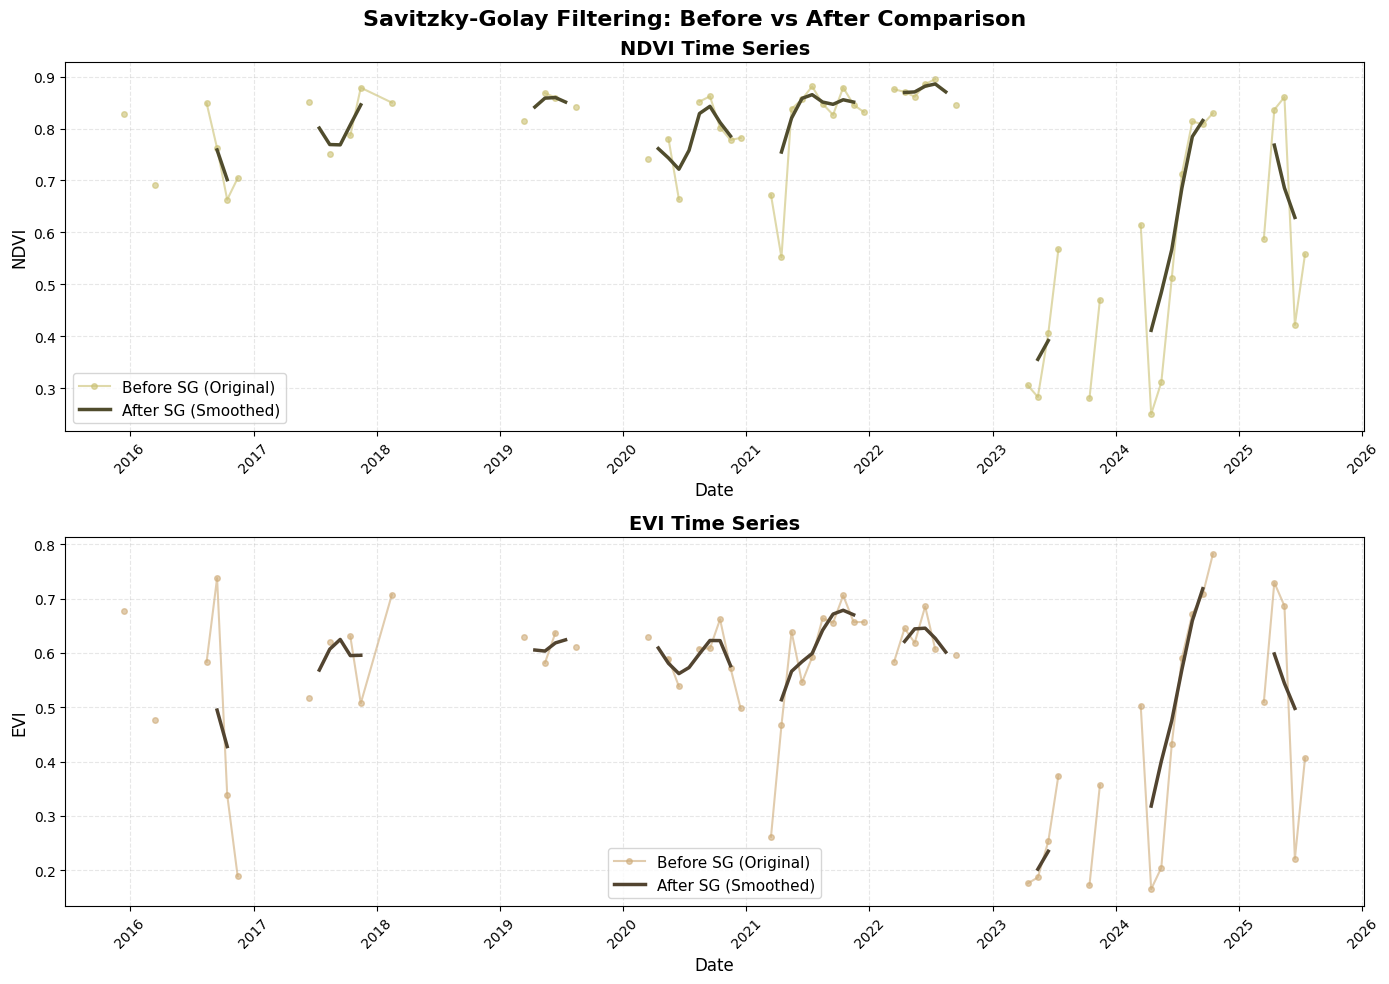

In [13]:
from forestry_carbon_arr.utils.gee_processing import (
    extract_time_series_for_visualization,
    plot_sg_comparison
)

# Extract time series
sample_point = ee.Geometry.Point([111.81746, -0.41587])
bands = ['NDVI', 'EVI']

df_before, df_after = extract_time_series_for_visualization(
    collection_before=collection_before_sg,
    collection_after=collection_with_sg,
    sample_point=sample_point,
    bands=bands,
    # time_dates=time_dates_source,  # Optional: from zarr dataset
    scale=10
)

# Plot comparison
plot_sg_comparison(df_before, df_after, bands)

In [14]:
## With interpolation filling gap
df_before, df_after = extract_time_series_for_visualization(
    collection_before=collection_before_sg,
    collection_after=collection_monthly_filled,
    sample_point=sample_point,
    bands=bands,
    # time_dates=time_dates_source,  # Optional: from zarr dataset
    scale=10
)

# Plot comparison
plot_sg_comparison(df_before, df_after, bands)

EEException: Earth Engine capacity exceeded.

In [ ]:
# STEP 6: Convert to xarray using xee
print("\n" + "=" * 60)
print("STEP 6: Convert to xarray using xee")
print("=" * 60)

import xarray as xr

utm_crs = forestry.config['output_crs']
pixel_scale = forestry.config['resolution_satellite']

# Convert AOI geometry to UTM for xee
aoi_gpd_utm = aoi_gpd.to_crs(utm_crs)
aoi_gpd_utm.set_crs(utm_crs, inplace=True)
aoi_ee_utm_geom = geemap.geopandas_to_ee(aoi_gpd_utm).geometry()

print(f"   CRS: {utm_crs}")
print(f"   Scale: {pixel_scale}m")
print("   Converting...")

ds = xr.open_dataset(
    collection_monthly_filled,
    engine='ee',
    crs=utm_crs,
    scale=pixel_scale,
    geometry=aoi_ee_utm_geom
)

print(f"✅ Dataset created: {dict(ds.sizes)}")
print(f"   Data variables: {list(ds.data_vars)}")


In [ ]:
ds

In [15]:
# STEP 7: Rename dimensions and save/load from zarr
print("\n" + "=" * 60)
print("STEP 7: Save to zarr and reload (to avoid GEE server errors)")
print("=" * 60)

from forestry_carbon_arr.utils.zarr_utils import save_dataset_efficient_zarr, load_dataset_zarr
import os

use_exported_ds = True

# Determine zarr path
zarr_path = os.getenv('GCS_ZARR_DIR', '')
if zarr_path:
    if not zarr_path.startswith('gs://'):
        zarr_path = f"gs://{zarr_path}/ds_resampled_merged.zarr"
    else:
        zarr_path = f"{zarr_path}/ds_resampled_merged.zarr"
    storage = 'gcs'
    print(f"   Saving to GCS: {zarr_path}")
else:
    zarr_path = os.path.join(os.getcwd(), 'data', 'ds_resampled_merged.zarr')
    storage = 'local'
    print(f"   Saving to local: {zarr_path}")

if use_exported_ds != True:

    # Rename dimensions (X, Y -> x, y)
    ds_resampled = ds.rename({'X': 'x', 'Y': 'y'})

    # Save to zarr
    chunk_sizes = {'time': 40, 'x': 1024, 'y': 1024}
    print("   Saving dataset to zarr...")
    save_dataset_efficient_zarr(
        ds_resampled,
        zarr_path,
        chunk_sizes=chunk_sizes,
        compression='lz4',
        compression_level=1,
        overwrite=True,
        storage=storage
    )
    print(f"✅ Dataset saved to zarr")

    # Load from zarr to avoid GEE server-side errors
    print(f"\n   Loading from: {zarr_path}")
else:
    ds_resampled = load_dataset_zarr(zarr_path, storage=storage)

print(f"✅ Dataset loaded from zarr")
print(f"   Dataset: {dict(ds_resampled.sizes)}")
print(f"   Variables: {list(ds_resampled.data_vars)}")
print(f"\n✅ ds_resampled_merged ready for tsfresh processing")



STEP 7: Save to zarr and reload (to avoid GEE server errors)
   Saving to GCS: gs://remote_sensing_saas/01-korindo/timeseries_zarr/ds_resampled_merged.zarr
📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/ds_resampled_merged.zarr
✅ Dataset loaded: {'time': 106, 'x': 4489, 'y': 3213}
✅ Dataset loaded from zarr
   Dataset: {'time': 106, 'x': 4489, 'y': 3213}
   Variables: ['EVI', 'NDVI']

✅ ds_resampled_merged ready for tsfresh processing


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:833: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


In [16]:
ds_resampled

<xarray.Dataset> Size: 12GB
Dimensions:  (time: 106, x: 4489, y: 3213)
Coordinates:
  * time     (time) datetime64[ns] 848B 2015-11-15 2015-12-15 ... 2025-08-15
  * x        (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * y        (y) float64 26kB 9.949e+06 9.949e+06 ... 9.982e+06 9.982e+06
Data variables:
    EVI      (time, x, y) float32 6GB dask.array<chunksize=(40, 1024, 1024), meta=np.ndarray>
    NDVI     (time, x, y) float32 6GB dask.array<chunksize=(40, 1024, 1024), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749

In [17]:
### Preparation for tsfresh
# Reload module to get latest fixes
import importlib
import forestry_carbon_arr.utils.tsfresh_utils
importlib.reload(forestry_carbon_arr.utils.tsfresh_utils)

# Check coordinate order before processing
print("Checking ds_resampled coordinate order:")
print(f"  X: {ds_resampled.x.values[0]:.2f} to {ds_resampled.x.values[-1]:.2f} ({'ascending' if ds_resampled.x.values[0] < ds_resampled.x.values[-1] else 'descending'})")
print(f"  Y: {ds_resampled.y.values[0]:.2f} to {ds_resampled.y.values[-1]:.2f} ({'ascending' if ds_resampled.y.values[0] < ds_resampled.y.values[-1] else 'descending'})")
print("\nNote: Dataset will be standardized to STAC convention (y descending, x ascending) automatically")

Checking ds_resampled coordinate order:
  X: 578619.54 to 623499.54 (ascending)
  Y: 9949396.12 to 9981516.12 (ascending)

Note: Dataset will be standardized to STAC convention (y descending, x ascending) automatically


In [18]:
# Prepare tsfresh data with ground truth
# This is the main method that does everything!

ground_truth_path = 'gs://remote_sensing_saas/01-korindo/sample_tsfresh/20251112_df_long.parquet'

ds_gt_list = forestry.prepare_tsfresh_with_ground_truth(
    ds_resampled=ds_resampled,  # From Step 1
    ground_truth_path=ground_truth_path,  # GCS or local path to parquet
    buffer_pixels=50,  # Buffer around sample bboxes
    save_to_zarr=False,  # Save to zarr for efficient access
    zarr_path=None,  # Auto-detects from GCS_ZARR_DIR env var
    overwrite_zarr=False,  # Don't overwrite if exists
    storage='auto'
)

print(f"\n✅ Prepared {len(ds_gt_list)} sample datasets")
for i, ds_gt in enumerate(ds_gt_list):
    plot_id = ds_gt.coords['plot_id'].values[0] if 'plot_id' in ds_gt.coords else f'sample_{i+1}'
    print(f"   {plot_id}: {dict(ds_gt.sizes)}")
    print(f"      Variables: {list(ds_gt.data_vars)}")


/usr/src/app/forestry_carbon_arr/utils/tsfresh_utils.py:407: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  logger.info(f"  ✓ Final dimensions: {dict(gt.dims)}")
/usr/src/app/forestry_carbon_arr/utils/tsfresh_utils.py:407: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  logger.info(f"  ✓ Final dimensions: {dict(gt.dims)}")



✅ Prepared 3 sample datasets
   sample_3: {'time': 111, 'x': 414, 'y': 341, 'plot_id': 1}
      Variables: ['EVI', 'NDVI', 'ground_truth', 'gt_valid']
   sample_2: {'time': 112, 'x': 413, 'y': 301, 'plot_id': 1}
      Variables: ['EVI', 'NDVI', 'ground_truth', 'gt_valid']
   sample_1: {'time': 111, 'x': 322, 'y': 231, 'plot_id': 1}
      Variables: ['EVI', 'NDVI', 'ground_truth', 'gt_valid']


/usr/src/app/forestry_carbon_arr/utils/tsfresh_utils.py:407: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  logger.info(f"  ✓ Final dimensions: {dict(gt.dims)}")


In [19]:
import pandas as pd
import numpy as np

# Inspect first sample dataset
if len(ds_gt_list) > 0:
    ds_gt = ds_gt_list[0]
    plot_id = ds_gt.coords['plot_id'].values[0] if 'plot_id' in ds_gt.coords else 'sample_1'
    
    print(f"Sample: {plot_id}")
    print(f"Dimensions: {dict(ds_gt.sizes)}")
    print(f"Variables: {list(ds_gt.data_vars)}")
    print(f"\nTime range: {pd.to_datetime(ds_gt.time.min().values)} to {pd.to_datetime(ds_gt.time.max().values)}")
    
    # Check ground truth statistics
    if 'ground_truth' in ds_gt.data_vars:
        gt_values = ds_gt['ground_truth'].values.flatten()
        n_total = len(gt_values)
        n_nan = np.isnan(gt_values).sum()
        n_zeros = (gt_values == 0).sum()
        n_ones = (gt_values == 1).sum()
        
        print(f"\nGround Truth Statistics:")
        print(f"  Total pixels: {n_total:,}")
        print(f"  NaN (no label): {n_nan:,} ({100*n_nan/n_total:.1f}%)")
        print(f"  0 (non-tree): {n_zeros:,} ({100*n_zeros/n_total:.1f}%)")
        print(f"  1 (tree): {n_ones:,} ({100*n_ones/n_total:.1f}%)")
    
    # Show dataset structure
    print(f"\nDataset structure:")
    print(ds_gt)


Sample: sample_3
Dimensions: {'time': 111, 'x': 414, 'y': 341, 'plot_id': 1}
Variables: ['EVI', 'NDVI', 'ground_truth', 'gt_valid']

Time range: 2015-11-15 00:00:00 to 2025-09-15 00:00:00

Ground Truth Statistics:
  Total pixels: 15,670,314
  NaN (no label): 13,453,671 (85.9%)
  0 (non-tree): 1,112,030 (7.1%)
  1 (tree): 1,104,613 (7.0%)

Dataset structure:
<xarray.Dataset> Size: 313MB
Dimensions:       (time: 111, x: 414, y: 341, plot_id: 1)
Coordinates:
  * time          (time) datetime64[ns] 888B 2015-11-15 ... 2025-09-15
  * x             (x) float64 3kB 5.828e+05 5.828e+05 ... 5.869e+05 5.869e+05
  * y             (y) float64 3kB 9.971e+06 9.971e+06 ... 9.967e+06 9.967e+06
  * plot_id       (plot_id) object 8B 'sample_3'
    epsg          int64 8B 32749
Data variables:
    EVI           (plot_id, time, x, y) float32 63MB dask.array<chunksize=(1, 20, 128, 128), meta=np.ndarray>
    NDVI          (plot_id, time, x, y) float32 63MB dask.array<chunksize=(1, 20, 128, 128), meta=np.ndar

VISUALIZING GROUND TRUTH: sample_3 at 2025-09-15


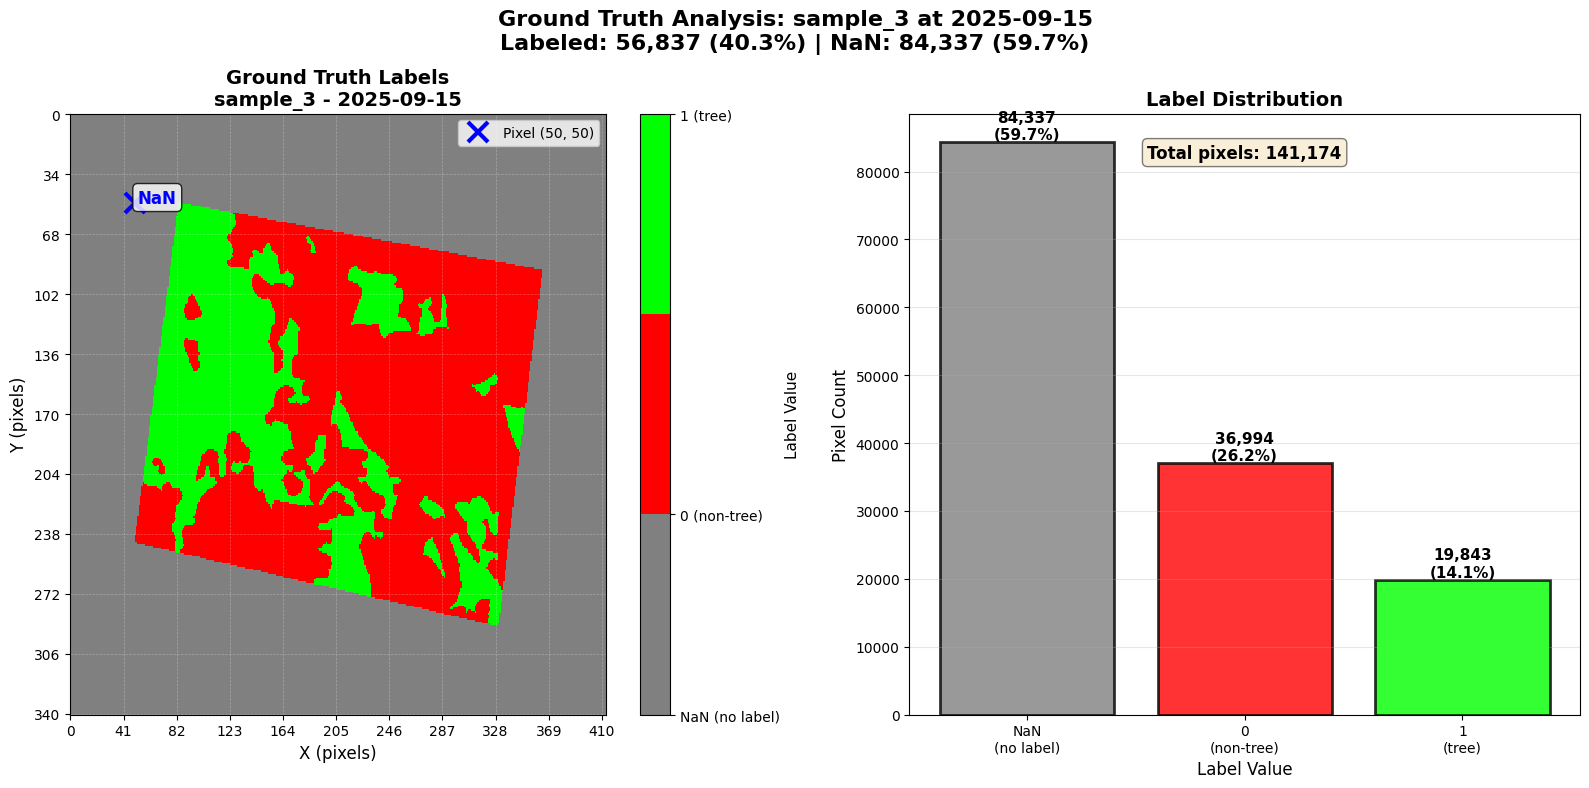


STATISTICS:
Total pixels: 141,174
  NaN (no label): 84,337 (59.74%)
  0 (non-tree):   36,994 (26.20%)
  1 (tree):       19,843 (14.06%)

Labeled pixels: 56,837 (40.26%)


In [20]:
# ============================================================================
# VISUALIZE: Ground Truth Labels Only (1, 0, NaN)
# ============================================================================
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

plot_name = 'sample_3'
time_str = '2025-09-15'

print("=" * 60)
print(f"VISUALIZING GROUND TRUTH: {plot_name} at {time_str}")
print("=" * 60)

ds = ds_gt

# Get ground truth slice
gt_slice = ds['ground_truth'].sel(plot_id=plot_name, time=time_str)

# Prepare data for visualization
gt_values = gt_slice.values.copy()
# Map: NaN -> -1, 0 -> 0, 1 -> 2 (for colormap indexing)
gt_plot = np.full_like(gt_values, -1, dtype=float)
gt_plot[gt_values == 0] = 0
gt_plot[gt_values == 1] = 2
gt_plot[np.isnan(gt_values)] = -1

# Count values
values = gt_values.flatten()
n_nan = np.isnan(values).sum()
n_zeros = (values == 0).sum()
n_ones = (values == 1).sum()
n_total = len(values)

# Create custom colormap: NaN=gray, 0=red, 1=green
colors = ['#808080', '#FF0000', '#00FF00']  # gray, red, green
cmap_custom = ListedColormap(colors)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Ground Truth Labels
ax1 = axes[0]
im1 = ax1.imshow(gt_plot, cmap=cmap_custom, vmin=-1, vmax=2, aspect='auto', interpolation='nearest')
ax1.set_title(f'Ground Truth Labels\n{plot_name} - {time_str}', fontsize=14, fontweight='bold')
ax1.set_xlabel('X (pixels)', fontsize=12)
ax1.set_ylabel('Y (pixels)', fontsize=12)

# Add grid
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, color='white')
ax1.set_xticks(range(0, gt_slice.shape[1], max(1, gt_slice.shape[1]//10)))
ax1.set_yticks(range(0, gt_slice.shape[0], max(1, gt_slice.shape[0]//10)))

# Add colorbar
cbar1 = plt.colorbar(im1, ax=ax1, ticks=[-1, 0, 2])
cbar1.set_ticklabels(['NaN (no label)', '0 (non-tree)', '1 (tree)'])
cbar1.set_label('Label Value', fontsize=11)

# Mark specific pixel if checking
check_x, check_y = 50, 50
if 0 <= check_x < gt_slice.shape[1] and 0 <= check_y < gt_slice.shape[0]:
    ax1.plot(check_x, check_y, 'bx', markersize=15, markeredgewidth=3, 
             label=f'Pixel ({check_x}, {check_y})')
    pixel_val = gt_values[check_y, check_x]
    if np.isnan(pixel_val):
        label_text = 'NaN'
    else:
        label_text = f'{int(pixel_val)}'
    ax1.text(check_x + 2, check_y, label_text, color='blue', 
             fontsize=12, fontweight='bold', bbox=dict(boxstyle='round', 
             facecolor='white', alpha=0.8))
    ax1.legend(loc='upper right', fontsize=10)

# Plot 2: Statistics Bar Chart
ax2 = axes[1]
categories = ['NaN\n(no label)', '0\n(non-tree)', '1\n(tree)']
counts = [n_nan, n_zeros, n_ones]
colors_bar = ['#808080', '#FF0000', '#00FF00']
percentages = [100 * c / n_total for c in counts]

bars = ax2.bar(categories, counts, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_title('Label Distribution', fontsize=14, fontweight='bold')
ax2.set_ylabel('Pixel Count', fontsize=12)
ax2.set_xlabel('Label Value', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
for bar, pct, count in zip(bars, percentages, counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(count):,}\n({pct:.1f}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add total count text
ax2.text(0.5, 0.95, f'Total pixels: {n_total:,}',
         transform=ax2.transAxes, ha='center', va='top',
         fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle(f'Ground Truth Analysis: {plot_name} at {time_str}\n'
             f'Labeled: {n_zeros + n_ones:,} ({100*(n_zeros+n_ones)/n_total:.1f}%) | '
             f'NaN: {n_nan:,} ({100*n_nan/n_total:.1f}%)',
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\n" + "=" * 60)
print("STATISTICS:")
print("=" * 60)
print(f"Total pixels: {n_total:,}")
print(f"  NaN (no label): {n_nan:,} ({100*n_nan/n_total:.2f}%)")
print(f"  0 (non-tree):   {n_zeros:,} ({100*n_zeros/n_total:.2f}%)")
print(f"  1 (tree):       {n_ones:,} ({100*n_ones/n_total:.2f}%)")
print(f"\nLabeled pixels: {n_zeros + n_ones:,} ({100*(n_zeros+n_ones)/n_total:.2f}%)")


In [21]:
## check only gt_valid
# Quick random sampling
plot_name = 'sample_3'
time_str = '2025-09-15'
n_samples = 10

# Get valid pixels
gt_slice = ds['ground_truth'].sel(plot_id=plot_name, time=time_str)
valid_mask = ~np.isnan(gt_slice.values)
y_indices, x_indices = np.where(valid_mask)

# Random sample
random_idx = np.random.choice(len(y_indices), size=min(n_samples, len(y_indices)), replace=False)
sampled_y = y_indices[random_idx]
sampled_x = x_indices[random_idx]
sampled_gt = gt_slice.values[sampled_y, sampled_x]

# Get coordinates
x_coords = gt_slice.x.values[sampled_x]
y_coords = gt_slice.y.values[sampled_y]

# Results
for i, (x, y, gt, xc, yc) in enumerate(zip(sampled_x, sampled_y, sampled_gt, x_coords, y_coords)):
    label = 'tree' if gt == 1 else 'non-tree'
    print(f"Pixel {i+1}: ({x}, {y}) at ({xc:.2f}, {yc:.2f}) → GT={int(gt)} ({label})")


Pixel 1: (158, 93) at (584389.54, 9969616.12) → GT=1 (tree)
Pixel 2: (303, 192) at (585839.54, 9968626.12) → GT=0 (non-tree)
Pixel 3: (285, 103) at (585659.54, 9969516.12) → GT=0 (non-tree)
Pixel 4: (136, 176) at (584169.54, 9968786.12) → GT=1 (tree)
Pixel 5: (86, 70) at (583669.54, 9969846.12) → GT=1 (tree)
Pixel 6: (313, 151) at (585939.54, 9969036.12) → GT=0 (non-tree)
Pixel 7: (330, 201) at (586109.54, 9968536.12) → GT=0 (non-tree)
Pixel 8: (328, 233) at (586089.54, 9968216.12) → GT=1 (tree)
Pixel 9: (259, 241) at (585399.54, 9968136.12) → GT=0 (non-tree)
Pixel 10: (223, 235) at (585039.54, 9968196.12) → GT=1 (tree)


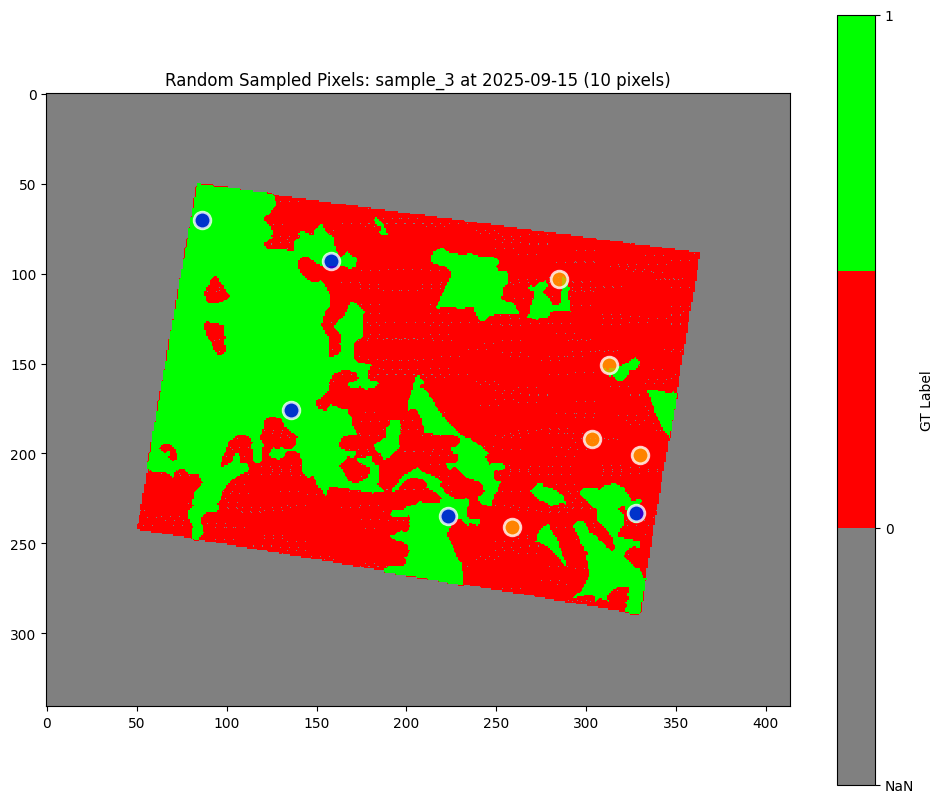

In [22]:
# Visualization (compact)
fig, ax = plt.subplots(figsize=(12, 10))
gt_plot = np.where(np.isnan(gt_slice.values), -1, np.where(gt_slice.values == 1, 2, 0))
ax.imshow(gt_plot, cmap=ListedColormap(['#808080', '#FF0000', '#00FF00']), vmin=-1, vmax=2, aspect='auto')
[ax.plot(x, y, 'o', markersize=12, markeredgecolor='white', markeredgewidth=2, 
         color='blue' if gt == 1 else 'orange', alpha=0.8) or 
 ax.text(x, y, f'{int(gt)}', color='white', fontsize=10, ha='center', va='center', fontweight='bold')
 for x, y, gt in zip(sampled_x, sampled_y, sampled_gt)]
ax.set_title(f'Random Sampled Pixels: {plot_name} at {time_str} ({len(sampled_x)} pixels)')
plt.colorbar(ax.imshow(gt_plot, cmap=ListedColormap(['#808080', '#FF0000', '#00FF00']), vmin=-1, vmax=2), 
             ax=ax, ticks=[-1, 0, 2], label='GT Label').set_ticklabels(['NaN', '0', '1'])
plt.show()

sample_3
sample_2
sample_1
RANDOM PIXEL TIMESERIES PLOTS:

Processing: sample_3
  Selected pixel: (y=34, x=260)
  Coordinates: (585409.54, 9970206.12)
  Timeseries: 111 time points, 0 labeled (0 tree, 0 non-tree)

Processing: sample_2
  Selected pixel: (y=37, x=176)
  Coordinates: (591089.54, 9952026.12)
  Timeseries: 112 time points, 0 labeled (0 tree, 0 non-tree)

Processing: sample_1
  Selected pixel: (y=89, x=230)
  Coordinates: (591079.54, 9954476.12)
  Timeseries: 111 time points, 36 labeled (14 tree, 22 non-tree)


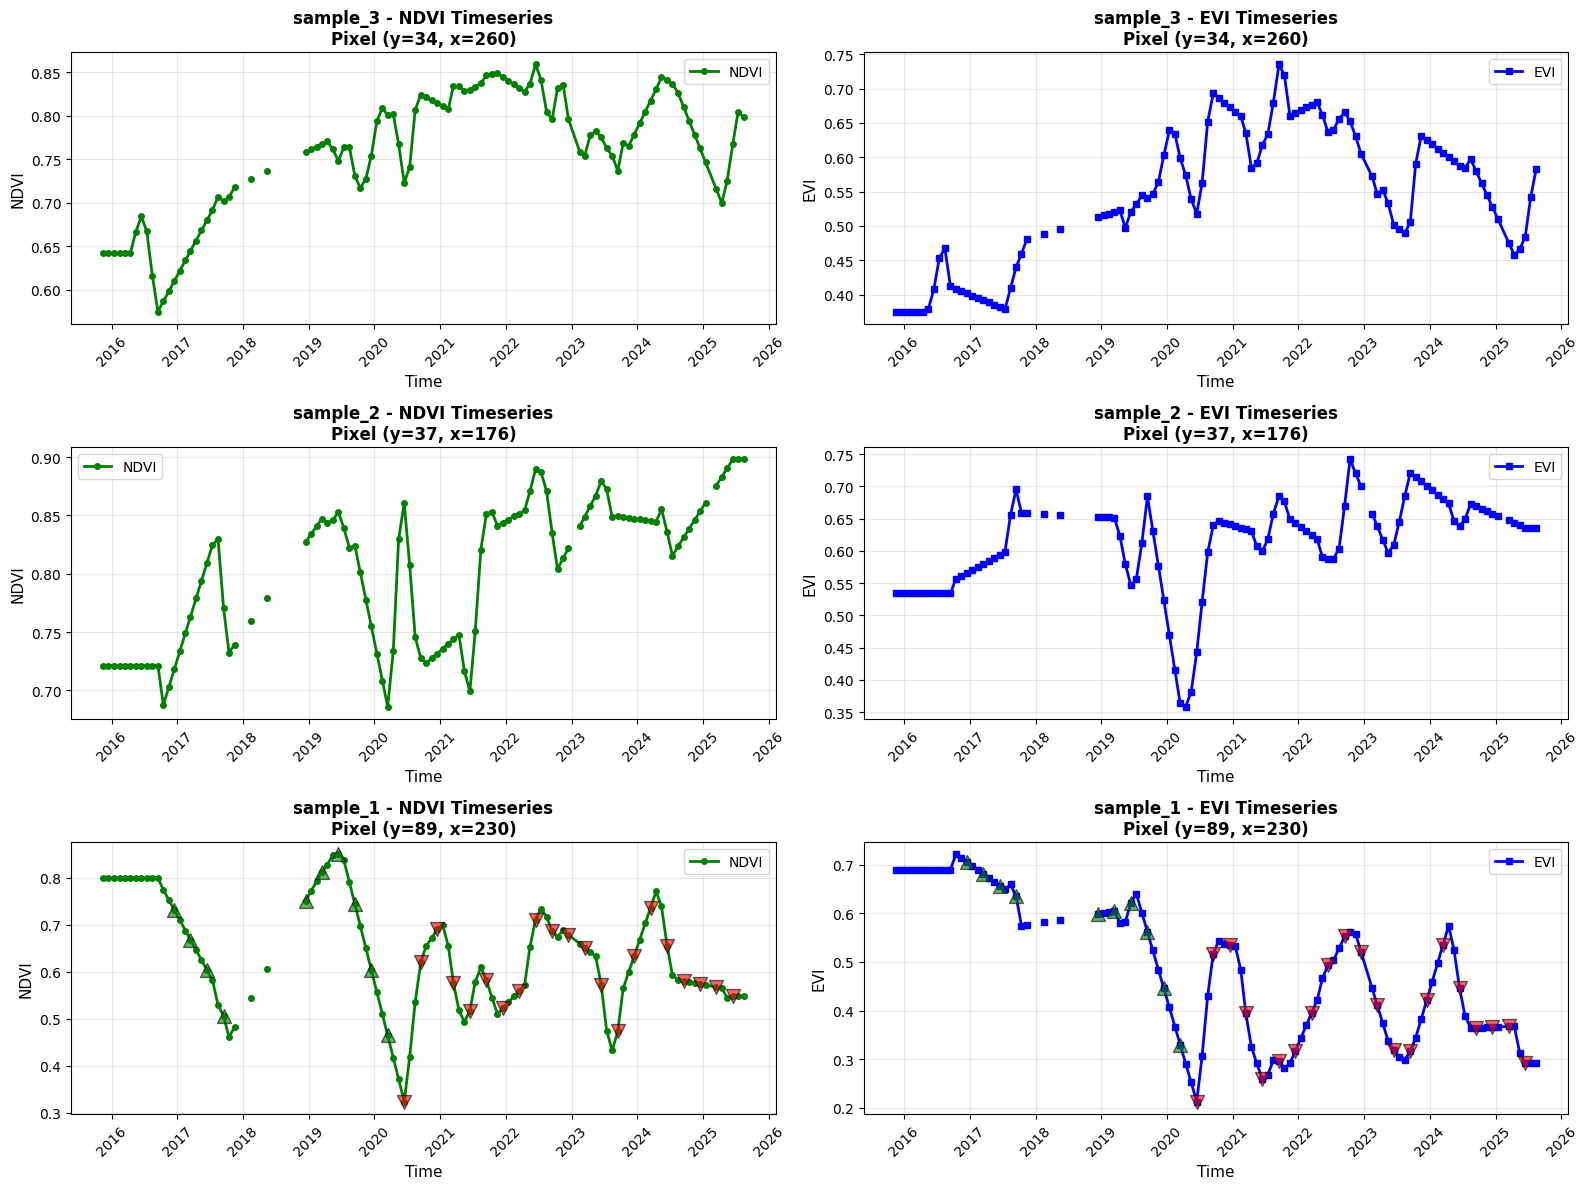


TIMESERIES PLOTS COMPLETE
Legend: Green triangle = tree (1), Red triangle = non-tree (0)


In [23]:
## visualization plot
for ds in ds_gt_list:
    print(ds.plot_id.item())  # Direct scalar extraction

# ============================================================================
# RANDOMLY SELECT VALID PIXEL AND PLOT TIMESERIES (NDVI, EVI) - FIXED
# ============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("=" * 60)
print("RANDOM PIXEL TIMESERIES PLOTS:")
print("=" * 60)

# Create subplots for all datasets
n_datasets = len(ds_gt_list)
fig, axes = plt.subplots(n_datasets, 2, figsize=(16, 4 * n_datasets))

if n_datasets == 1:
    axes = axes.reshape(1, -1)

for idx, ds in enumerate(ds_gt_list):
    plot_id = ds.plot_id.item()
    print(f"\nProcessing: {plot_id}")
    
    # Get gt_valid (should be per plot, so select plot_id)
    if 'plot_id' in ds['gt_valid'].dims:
        valid_mask = ds['gt_valid'].sel(plot_id=plot_id).values
    else:
        valid_mask = ds['gt_valid'].values
    
    # Find valid pixels (where gt_valid is True)
    valid_indices = np.where(valid_mask)
    
    if len(valid_indices[0]) == 0:
        print(f"  ⚠️  No valid pixels found for {plot_id}")
        continue
    
    # Randomly select one valid pixel
    random_idx = np.random.choice(len(valid_indices[0]))
    y_idx = valid_indices[0][random_idx]
    x_idx = valid_indices[1][random_idx]
    
    print(f"  Selected pixel: (y={y_idx}, x={x_idx})")
    
    # Get coordinates
    x_coord = float(ds.x.isel(x=x_idx).values)
    y_coord = float(ds.y.isel(y=y_idx).values)
    print(f"  Coordinates: ({x_coord:.2f}, {y_coord:.2f})")
    
    # Extract timeseries for this pixel - ensure we get 1D arrays
    if 'plot_id' in ds['NDVI'].dims:
        ndvi_ts = ds['NDVI'].sel(plot_id=plot_id).isel(y=y_idx, x=x_idx)
        evi_ts = ds['EVI'].sel(plot_id=plot_id).isel(y=y_idx, x=x_idx)
        gt_ts = ds['ground_truth'].sel(plot_id=plot_id).isel(y=y_idx, x=x_idx)
    else:
        ndvi_ts = ds['NDVI'].isel(y=y_idx, x=x_idx)
        evi_ts = ds['EVI'].isel(y=y_idx, x=x_idx)
        gt_ts = ds['ground_truth'].isel(y=y_idx, x=x_idx)
    
    # Convert to numpy arrays and ensure 1D
    time_values = pd.to_datetime(ndvi_ts.time.values)
    ndvi_values = np.atleast_1d(ndvi_ts.values).flatten()  # Ensure 1D
    evi_values = np.atleast_1d(evi_ts.values).flatten()    # Ensure 1D
    gt_values = np.atleast_1d(gt_ts.values).flatten()      # Ensure 1D
    
    # Plot NDVI
    ax1 = axes[idx, 0]
    ax1.plot(time_values, ndvi_values, 'g-', linewidth=2, label='NDVI', marker='o', markersize=4)
    ax1.set_title(f'{plot_id} - NDVI Timeseries\nPixel (y={y_idx}, x={x_idx})', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Time', fontsize=11)
    ax1.set_ylabel('NDVI', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.tick_params(axis='x', rotation=45)
    
    # Add ground truth labels as colored markers - FIXED
    for i, (t, gt_val) in enumerate(zip(time_values, gt_values)):
        # Convert to scalar if needed
        gt_scalar = float(gt_val) if not isinstance(gt_val, (list, np.ndarray)) else float(gt_val[0])
        
        if not np.isnan(gt_scalar):
            color = 'green' if gt_scalar == 1 else 'red'
            marker = '^' if gt_scalar == 1 else 'v'
            # Find corresponding NDVI value
            ndvi_val = ndvi_values[i]
            ax1.scatter(t, ndvi_val, color=color, marker=marker, s=100, 
                       alpha=0.6, edgecolors='black', linewidth=1, zorder=5)
    
    # Plot EVI
    ax2 = axes[idx, 1]
    ax2.plot(time_values, evi_values, 'b-', linewidth=2, label='EVI', marker='s', markersize=4)
    ax2.set_title(f'{plot_id} - EVI Timeseries\nPixel (y={y_idx}, x={x_idx})', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Time', fontsize=11)
    ax2.set_ylabel('EVI', fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)
    
    # Add ground truth labels as colored markers - FIXED
    for i, (t, gt_val) in enumerate(zip(time_values, gt_values)):
        # Convert to scalar if needed
        gt_scalar = float(gt_val) if not isinstance(gt_val, (list, np.ndarray)) else float(gt_val[0])
        
        if not np.isnan(gt_scalar):
            color = 'green' if gt_scalar == 1 else 'red'
            marker = '^' if gt_scalar == 1 else 'v'
            # Find corresponding EVI value
            evi_val = evi_values[i]
            ax2.scatter(t, evi_val, color=color, marker=marker, s=100, 
                       alpha=0.6, edgecolors='black', linewidth=1, zorder=5)
    
    # Print summary
    n_labeled = (~np.isnan(gt_values)).sum()
    n_trees = (gt_values == 1).sum()
    n_non_trees = (gt_values == 0).sum()
    print(f"  Timeseries: {len(time_values)} time points, {n_labeled} labeled ({n_trees} tree, {n_non_trees} non-tree)")

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("TIMESERIES PLOTS COMPLETE")
print("=" * 60)
print("Legend: Green triangle = tree (1), Red triangle = non-tree (0)")

In [25]:
# ds_gt_list

In [26]:
import os

### saving the xarray ds -> gt - sample groundtruth to the bucket
gcs_path_gt_root = 'gs://remote_sensing_saas/01-korindo/timeseries_zarr/plots/merged_mpc_gee'

for ds in ds_gt_list:
    plot_id = ds.plot_id.item()
    print(f'Saving dataset for sample_id: {plot_id}')
    
    # Drop image_id to avoid chunk alignment issues
    if 'image_id' in ds.data_vars: # problematic because we're not yet unchunk this, not needed for now
        ds = ds.drop_vars('image_id')
        print(f"  Dropped image_id variable")
    
    # Rechunk dataset
    ds_chunked = ds.chunk({
        'plot_id': 1,
        'time': 20,
        'x': 128,
        'y': 128
    })
    
    gcs_path = f'{gcs_path_gt_root}/{plot_id}_gt_pair_ds.zarr'
    
    # Save to GCS
    save_dataset_efficient_zarr(
        ds_chunked,
        gcs_path,
        chunk_sizes={'plot_id': 1, 'time': 40, 'x': 128, 'y': 128},
        compression='lz4',
        compression_level=1,
        overwrite=True,
        consolidated=True,
        storage='gcs',
        align_chunks=True
    )
    print(f'Saved dataset for sample_id: {plot_id}')
    print('\n')

Saving dataset for sample_id: sample_3
🗑️  Removing existing GCS zarr store: gs://remote_sensing_saas/01-korindo/timeseries_zarr/plots/merged_mpc_gee/sample_3_gt_pair_ds.zarr


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:635: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"   Dimensions: {dict(ds.dims)}")
/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:688: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  dims = list(ds.dims.keys())
GEE requires last two dimensions to be Y and X (spatial). Found: ['y', 'plot_id']. GEE may have issues loading this array.


📦 Saving to zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/plots/merged_mpc_gee/sample_3_gt_pair_ds.zarr
   🌍 GEE-compatible format (Zarr v2)
   Dimensions: {'time': 111, 'x': 414, 'y': 341, 'plot_id': 1}
   Chunks: {'plot_id': 1, 'time': 40, 'x': 128, 'y': 128}
   Compression: lz4 (level 1)
   Zarr version: 2
   Consolidated metadata: True
   Storage: gcs
💾 Writing to zarr (with automatic parallelism)...


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:707: FutureWarning: zarr_version is deprecated, use zarr_format
  ds_chunked.to_zarr(


[########################################] | 100% Completed | 8.91 sms
✅ Dataset saved successfully!
   Store size: 94.42 MB
   Time: 13.5 seconds (0.2 minutes)
   Write speed: 7.0 MB/s
   Path: gs://remote_sensing_saas/01-korindo/timeseries_zarr/plots/merged_mpc_gee/sample_3_gt_pair_ds.zarr
Saved dataset for sample_id: sample_3


Saving dataset for sample_id: sample_2
🗑️  Removing existing GCS zarr store: gs://remote_sensing_saas/01-korindo/timeseries_zarr/plots/merged_mpc_gee/sample_2_gt_pair_ds.zarr


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:635: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"   Dimensions: {dict(ds.dims)}")
/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:688: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  dims = list(ds.dims.keys())
GEE requires last two dimensions to be Y and X (spatial). Found: ['y', 'plot_id']. GEE may have issues loading this array.


📦 Saving to zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/plots/merged_mpc_gee/sample_2_gt_pair_ds.zarr
   🌍 GEE-compatible format (Zarr v2)
   Dimensions: {'time': 112, 'x': 413, 'y': 301, 'plot_id': 1}
   Chunks: {'plot_id': 1, 'time': 40, 'x': 128, 'y': 128}
   Compression: lz4 (level 1)
   Zarr version: 2
   Consolidated metadata: True
   Storage: gcs
💾 Writing to zarr (with automatic parallelism)...


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:707: FutureWarning: zarr_version is deprecated, use zarr_format
  ds_chunked.to_zarr(


[########################################] | 100% Completed | 5.92 sms
✅ Dataset saved successfully!
   Store size: 82.73 MB
   Time: 10.4 seconds (0.2 minutes)
   Write speed: 7.9 MB/s
   Path: gs://remote_sensing_saas/01-korindo/timeseries_zarr/plots/merged_mpc_gee/sample_2_gt_pair_ds.zarr
Saved dataset for sample_id: sample_2


Saving dataset for sample_id: sample_1
🗑️  Removing existing GCS zarr store: gs://remote_sensing_saas/01-korindo/timeseries_zarr/plots/merged_mpc_gee/sample_1_gt_pair_ds.zarr


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:635: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"   Dimensions: {dict(ds.dims)}")
/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:688: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  dims = list(ds.dims.keys())
GEE requires last two dimensions to be Y and X (spatial). Found: ['y', 'plot_id']. GEE may have issues loading this array.


📦 Saving to zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/plots/merged_mpc_gee/sample_1_gt_pair_ds.zarr
   🌍 GEE-compatible format (Zarr v2)
   Dimensions: {'time': 111, 'x': 322, 'y': 231, 'plot_id': 1}
   Chunks: {'plot_id': 1, 'time': 40, 'x': 128, 'y': 128}
   Compression: lz4 (level 1)
   Zarr version: 2
   Consolidated metadata: True
   Storage: gcs
💾 Writing to zarr (with automatic parallelism)...


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:707: FutureWarning: zarr_version is deprecated, use zarr_format
  ds_chunked.to_zarr(


[########################################] | 100% Completed | 6.92 sms
✅ Dataset saved successfully!
   Store size: 49.45 MB
   Time: 11.1 seconds (0.2 minutes)
   Write speed: 4.4 MB/s
   Path: gs://remote_sensing_saas/01-korindo/timeseries_zarr/plots/merged_mpc_gee/sample_1_gt_pair_ds.zarr
Saved dataset for sample_id: sample_1




In [27]:
ds_gt_list[0]

<xarray.Dataset> Size: 313MB
Dimensions:       (time: 111, x: 414, y: 341, plot_id: 1)
Coordinates:
  * time          (time) datetime64[ns] 888B 2015-11-15 ... 2025-09-15
  * x             (x) float64 3kB 5.828e+05 5.828e+05 ... 5.869e+05 5.869e+05
  * y             (y) float64 3kB 9.971e+06 9.971e+06 ... 9.967e+06 9.967e+06
  * plot_id       (plot_id) object 8B 'sample_3'
    epsg          int64 8B 32749
Data variables:
    EVI           (plot_id, time, x, y) float32 63MB dask.array<chunksize=(1, 20, 128, 128), meta=np.ndarray>
    NDVI          (plot_id, time, x, y) float32 63MB dask.array<chunksize=(1, 20, 128, 128), meta=np.ndarray>
    ground_truth  (plot_id, time, y, x) float32 63MB dask.array<chunksize=(1, 20, 128, 128), meta=np.ndarray>
    gt_valid      (plot_id, time, y, x) float64 125MB dask.array<chunksize=(1, 20, 128, 128), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749

In [28]:
from tqdm.auto import tqdm

## MERGING
dss = []
for ds in tqdm(ds_gt_list):
    try:
        layer = ds.plot_id.item()
        # ds = ds.resample(time='3D').mean()
        # Now stack the spatial dimensions into a single "pixel" dimension:
        ds_stacked = ds.stack(pixel=("y", "x"))

        # Create a mask. Adjust the condition if needed (e.g., if gt_valid uses 0/1 instead of booleans):
        mask = ds_stacked["gt_valid"].all(dim="time").compute()

        # Filter out the pixels where the mask is False:
        ds_filtered = ds_stacked.where(mask, drop=True)
        
        dss.append(ds_filtered)
    except Exception as e:
        print(f"Error with {layer}: {e}")


  0%|          | 0/3 [00:00<?, ?it/s]

In [30]:
import xarray as xr

def prepare_ds(ds):
    # Remove the singleton "plot" dimension.
    ds = ds.squeeze("plot_id")
    # Extract the plot id (e.g. "plot_1") from the dataset.
    plot_id = ds.coords["plot_id"].item()
    # Create a new coordinate along "pixel" that records the original plot id for each pixel.
    ds = ds.assign_coords(plot_id=("pixel", np.full(len(ds.pixel), plot_id)))
    return ds

# Assume you have your datasets in a list, e.g. [ds1, ds2, ds3]
ds_list = [prepare_ds(ds) for ds in dss]

# Concatenate along the "pixel" dimension.
merged_ds = xr.concat(ds_list, dim="pixel")
ds = merged_ds

In [31]:
# create a new "season" coordinate: if month > 2 use current year, otherwise use previous year
ds = ds.assign_coords(
    season=("time",
            xr.where(ds.time.dt.month > 2,
                     ds.time.dt.year,
                     ds.time.dt.year - 1).values)
)
# for x,y in zip(ds.isel(pixel=0).time.values[:100], ds.isel(pixel=0).season.values[:100]):
#    print(f"{x} - {y}")
ds

<xarray.Dataset> Size: 307MB
Dimensions:       (time: 113, pixel: 132576)
Coordinates:
  * time          (time) datetime64[ns] 904B 2015-11-15 ... 2025-09-15
  * pixel         (pixel) object 1MB MultiIndex
  * y             (pixel) float64 1MB 9.97e+06 9.97e+06 ... 9.954e+06 9.954e+06
  * x             (pixel) float64 1MB 5.836e+05 5.837e+05 ... 5.894e+05
    plot_id       (pixel) <U8 4MB 'sample_3' 'sample_3' ... 'sample_1'
    epsg          int64 8B 32749
    season        (time) int64 904B 2015 2015 2015 2015 ... 2025 2025 2025 2025
Data variables:
    EVI           (time, pixel) float32 60MB dask.array<chunksize=(18, 11764), meta=np.ndarray>
    NDVI          (time, pixel) float32 60MB dask.array<chunksize=(18, 11764), meta=np.ndarray>
    ground_truth  (time, pixel) float32 60MB dask.array<chunksize=(18, 11764), meta=np.ndarray>
    gt_valid      (time, pixel) float64 120MB dask.array<chunksize=(18, 11764), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749

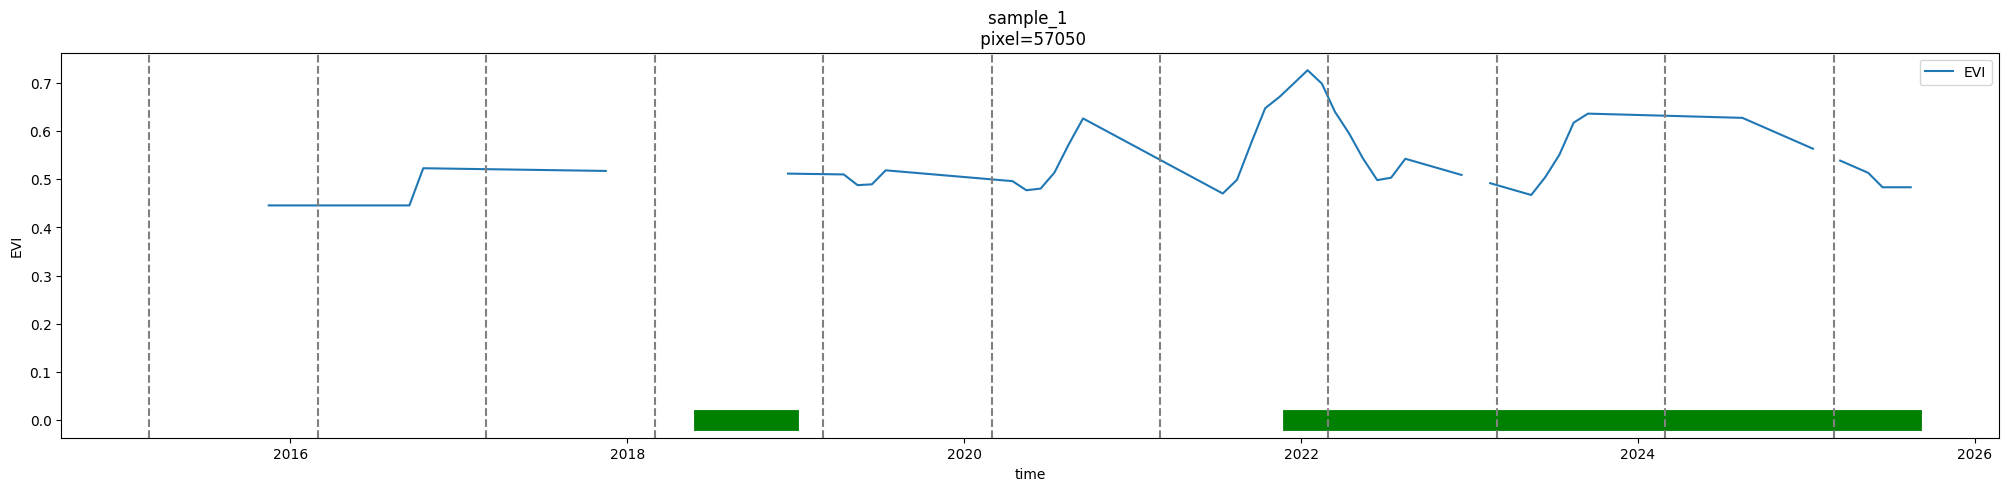

In [34]:
import random

pixel = random.randint(0, ds.pixel.size - 1)

plt.figure(figsize=(25, 5))
gt_trees = (ds.ground_truth.isel(pixel=pixel) == 1)
(gt_trees.where(gt_trees) - 1).plot(color='green', linewidth=15)
gt_non_trees = (ds.ground_truth.isel(pixel=pixel) == 0)
(gt_non_trees.where(gt_non_trees) - 1).plot(color='red', linewidth=15)

ds.EVI.isel(pixel=pixel).plot(label='EVI')
plt.title(f"{layer} \n pixel={pixel}")

# plot line each febuary
start_year = pd.to_datetime(ds.time.values[0]).year
end_year = pd.to_datetime(ds.time.values[-1]).year
for year in range(start_year, end_year + 1):
    plt.axvline(x=pd.to_datetime(f"{year}-03-01"), color='gray', linestyle='--')
plt.legend()
plt.show()

In [50]:
# RESHAPE
# Determine the fixed-length (median number of time steps) across seasons.
max_length = int(np.median([group.sizes["time"] for _, group in ds.groupby("season")]))

# Lists to collect samples for EVI (X), target (Y), and plot labels.
X_list = []
y_list = []
plot_list = []
season_list = []
cords_x_list = []
cords_y_list = []

# Loop over each season group.
for season, group in ds.groupby("season"):
    # Number of pixels and time steps in the current season.
    n_pixels = group.sizes["pixel"]
    n_time = group.sizes["time"]
    
    # Create an array for EVI + NDVI with shape (n_pixels, max_length, 2) and fill with NaNs.
    # Channel 0 -> EVI, Channel 1 -> NDVI
    X_season = np.full((n_pixels, max_length, 2), np.nan)
    
    # Extract EVI and NDVI values; shape will be (n_pixels, n_time) after transposition.
    evi_values = group["EVI"].transpose("pixel", "time").values
    ndvi_values = group["NDVI"].transpose("pixel", "time").values
    
    # Fill the first n_time values for each channel (truncate to max_length if needed).
    X_season[:, :n_time, 0] = evi_values[:, :max_length]
    X_season[:, :n_time, 1] = ndvi_values[:, :max_length]
    
    X_list.append(X_season)
    
    # Extract the target from 'gt': take the last value along the time axis.
    gt_last = group["ground_truth"].isel(time=-1).values
    y_list.append(gt_last)
    
    # Extract the plot information. 
    # Here, we're using the 'plot' coordinate, which has one value per pixel.
    plot_vals = group["plot_id"].values
    plot_list.append(plot_vals)

    # Extract the year from the time coordinate.
    season_list.append([int(season)]*n_pixels)

    # Extract the coordinates for the pixel.
    cords_x = group["x"].values
    cords_y = group["y"].values
    cords_x_list.append(cords_x)
    cords_y_list.append(cords_y)
    

# Concatenate all season samples into one training dataset.
X_train = np.concatenate(X_list, axis=0)  # Shape: (n_samples, max_length, 2)
y_train = np.concatenate(y_list, axis=0)
plot_train = np.concatenate(plot_list, axis=0)
seasion_train = np.concatenate(season_list, axis=0)
cords_x_train = np.concatenate(cords_x_list, axis=0)
cords_y_train = np.concatenate(cords_y_list, axis=0)

print("X_train shape:", X_train.shape)  # should be (N, max_length, 2)
print("y_train shape:", y_train.shape)
print("plot_train shape:", plot_train.shape)
print("seasion_train shape:", seasion_train.shape)
print("cords_x_train shape:", cords_x_train.shape)
print("cords_y_train shape:", cords_y_train.shape)

X_train shape: (1458336, 12, 2)
y_train shape: (1458336,)
plot_train shape: (1458336,)
seasion_train shape: (1458336,)
cords_x_train shape: (1458336,)
cords_y_train shape: (1458336,)


In [74]:
# X_train.shape == (n_samples, seq_length, n_channels)
n_samples, seq_length, n_channels = X_train.shape

ds_train = xr.Dataset(
    {
        "X": (("sample", "timestep", "channel"), X_train),
        "y": (("sample",), y_train),
        "plot_id": (("sample",), plot_train),
        "season": (("sample",), seasion_train),
        "coord_x": (("sample",), cords_x_train),
        "coord_y": (("sample",), cords_y_train),
    },
    coords={
        "sample": np.arange(n_samples),
        "timestep": np.arange(seq_length),
        "channel": ["EVI", "NDVI"],  # or range(n_channels)
    },
)

any_nulls = ds_train.X.isnull().any(dim=("timestep",'channel'))
# TODO this is too much of a drop, fixme.
print(f"Percentage of samples with Nan timesteps : {((all_nulls.sum() / all_nulls.size) * 100):.2f}%")
ds_train = ds_train.where(~all_nulls, drop=True)
ds_train

Percentage of samples with Nan timesteps : 54.55%


<xarray.Dataset> Size: 156MB
Dimensions:   (sample: 662880, timestep: 12, channel: 2)
Coordinates:
  * sample    (sample) int64 5MB 132576 132577 132578 ... 1193182 1193183
  * timestep  (timestep) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
  * channel   (channel) <U4 32B 'EVI' 'NDVI'
Data variables:
    X         (sample, timestep, channel) float64 127MB 0.5114 0.8547 ... 0.8591
    y         (sample) float32 3MB nan nan nan nan nan ... nan nan nan nan nan
    plot_id   (sample) object 5MB 'sample_3' 'sample_3' ... 'sample_1'
    season    (sample) float64 5MB 2.016e+03 2.016e+03 ... 2.023e+03 2.023e+03
    coord_x   (sample) float64 5MB 5.836e+05 5.837e+05 ... 5.894e+05 5.894e+05
    coord_y   (sample) float64 5MB 9.97e+06 9.97e+06 ... 9.954e+06 9.954e+06

In [75]:
# Any NaN in any channel at each timestep
nulls_fraction = (
    ds_train.X.isnull()
    .any(dim='channel')            # (sample, timestep)
    .sum(dim='timestep') / ds_train.timestep.size
)                                   # (sample,)

# Keep samples with some but not all NaNs over time
mask_sample = (nulls_fraction > 0) & (nulls_fraction < 1)

ds_train_missing = ds_train.isel(sample=mask_sample)

In [76]:
ds_train_missing # no missing ? because its already drop in the above if you done that

<xarray.Dataset> Size: 128B
Dimensions:   (sample: 0, timestep: 12, channel: 2)
Coordinates:
  * sample    (sample) int64 0B 
  * timestep  (timestep) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
  * channel   (channel) <U4 32B 'EVI' 'NDVI'
Data variables:
    X         (sample, timestep, channel) float64 0B 
    y         (sample) float32 0B 
    plot_id   (sample) object 0B 
    season    (sample) float64 0B 
    coord_x   (sample) float64 0B 
    coord_y   (sample) float64 0B

In [79]:
# ds_train_missing.isel(sample=100000).X.plot()

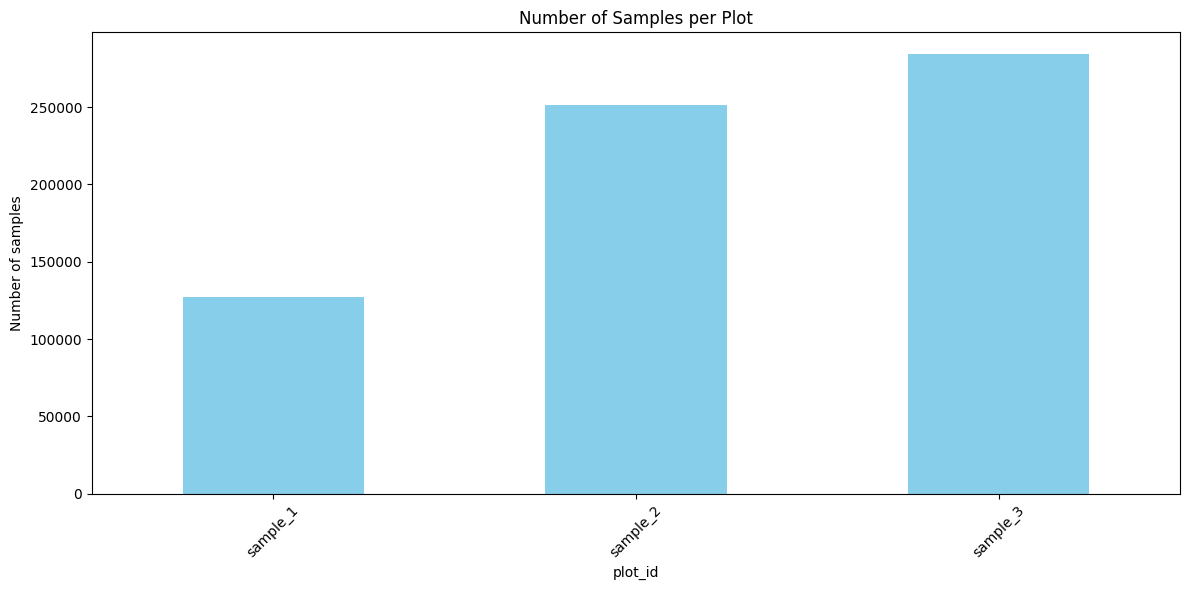

In [80]:
# Count the number of samples for each plot_id and plot as a bar chart
counts = pd.Series(ds_train.plot_id.values).value_counts().sort_index()

plt.figure(figsize=(12, 6))
counts.plot(kind='bar', color='skyblue')
plt.xlabel('plot_id')
plt.ylabel('Number of samples')
plt.title('Number of Samples per Plot')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Samples per season:
2016.0    132576
2019.0    132576
2020.0    132576
2021.0    132576
2023.0    132576
Name: count, dtype: int64


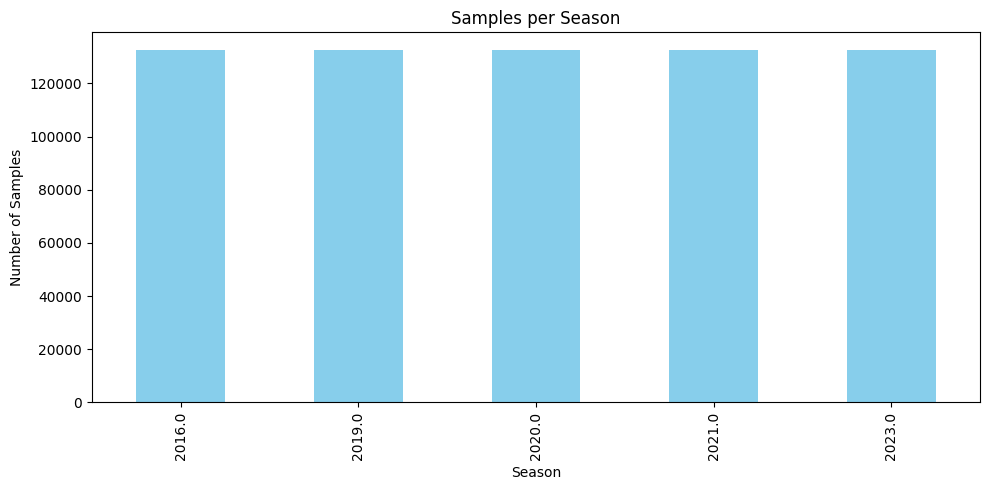

In [81]:
# Count number of samples per season
season_counts = pd.Series(ds_train.season.values).value_counts().sort_index()
print("Samples per season:")
print(season_counts)

# (Optional) visualize as bar chart
plt.figure(figsize=(10, 5))
season_counts.plot(kind="bar", color="skyblue")
plt.xlabel("Season")
plt.ylabel("Number of Samples")
plt.title("Samples per Season")
plt.tight_layout()
plt.show()

In [82]:
## NORMALIZED
# Z-normalize each time series in ds_train.X (mean=0, std=1)
# Compute normalized data as a DataArray
normed = (ds_train.X - ds_train.X.mean(dim='timestep')) / ds_train.X.std(dim='timestep')
# Assign raw numpy values to the variable
ds_train['X_normalized'] = (('sample', 'timestep','channel'), normed.data)

In [83]:
# convert plot_id to string
ds_train['plot_id'] = ds_train['plot_id'].astype(str)
gcs_path_ds_train = 'gs://remote_sensing_saas/01-korindo/timeseries_zarr/ds_train.zarr'

save_dataset_efficient_zarr(
    ds_train,
    gcs_path_ds_train,
    chunk_sizes={"sample": 100_000, "timestep": ds_train.timestep.size},
    consolidated=True,
    zarr_version=2,
    compression='lz4',
    compression_level=1,
    overwrite=True,
    storage='gcs',
    align_chunks=True
    
)

🗑️  Removing existing GCS zarr store: gs://remote_sensing_saas/01-korindo/timeseries_zarr/ds_train.zarr


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:635: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"   Dimensions: {dict(ds.dims)}")
/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:688: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  dims = list(ds.dims.keys())
GEE requires last two dimensions to be Y and X (spatial). Found: ['timestep', 'channel']. GEE may have issues loading this array.


📦 Saving to zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/ds_train.zarr
   🌍 GEE-compatible format (Zarr v2)
   Dimensions: {'sample': 662880, 'timestep': 12, 'channel': 2}
   Chunks: {'sample': 100000, 'timestep': 12}
   Compression: lz4 (level 1)
   Zarr version: 2
   Consolidated metadata: True
   Storage: gcs
💾 Writing to zarr (with automatic parallelism)...


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:707: FutureWarning: zarr_version is deprecated, use zarr_format
  ds_chunked.to_zarr(


[########################################] | 100% Completed | 1.74 sms
✅ Dataset saved successfully!
   Store size: 165.65 MB
   Time: 7.3 seconds (0.1 minutes)
   Write speed: 22.7 MB/s
   Path: gs://remote_sensing_saas/01-korindo/timeseries_zarr/ds_train.zarr


'gs://remote_sensing_saas/01-korindo/timeseries_zarr/ds_train.zarr'

In [84]:
ds_train = load_dataset_zarr(gcs_path_ds_train)
ds_train

📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/ds_train.zarr
✅ Dataset loaded: {'channel': 2, 'sample': 662880, 'timestep': 12}


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:833: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


<xarray.Dataset> Size: 300MB
Dimensions:       (channel: 2, sample: 662880, timestep: 12)
Coordinates:
  * channel       (channel) <U4 32B 'EVI' 'NDVI'
  * sample        (sample) int64 5MB 132576 132577 132578 ... 1193182 1193183
  * timestep      (timestep) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    coord_x       (sample) float64 5MB dask.array<chunksize=(100000,), meta=np.ndarray>
    coord_y       (sample) float64 5MB dask.array<chunksize=(100000,), meta=np.ndarray>
    plot_id       (sample) <U8 21MB dask.array<chunksize=(100000,), meta=np.ndarray>
    season        (sample) float64 5MB dask.array<chunksize=(100000,), meta=np.ndarray>
    X             (sample, timestep, channel) float64 127MB dask.array<chunksize=(100000, 12, 2), meta=np.ndarray>
    X_normalized  (sample, timestep, channel) float64 127MB dask.array<chunksize=(100000, 12, 2), meta=np.ndarray>
    y             (sample) float32 3MB dask.array<chunksize=(100000,), meta=np.ndarray>

In [85]:
## FEATURE EXTRACTION, feature
# Feature configuration - Define this early so it's available for feature extraction
selected_features_small = {'value': {'minimum': None,
  'quantile': [{'q': 0.1}, {'q': 0.2}, {'q': 0.3}],
  'variation_coefficient': None,
  'ar_coefficient': [{'coeff': 1, 'k': 10},
   {'coeff': 5, 'k': 10},
   {'coeff': 4, 'k': 10}],
  'cwt_coefficients': [{'coeff': 1, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 6, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 7, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 5, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 3, 'w': 2, 'widths': (2, 5, 10, 20)}],
  'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 3},
   {'num_segments': 10, 'segment_focus': 5},
   {'num_segments': 10, 'segment_focus': 9},
   {'num_segments': 10, 'segment_focus': 7},
   {'num_segments': 10, 'segment_focus': 6}],
  'fft_coefficient': [{'attr': 'real', 'coeff': 2},
   {'attr': 'imag', 'coeff': 36},
   {'attr': 'abs', 'coeff': 2},
   {'attr': 'real', 'coeff': 5},
   {'attr': 'angle', 'coeff': 13},
   {'attr': 'real', 'coeff': 10},
   {'attr': 'angle', 'coeff': 5},
   {'attr': 'abs', 'coeff': 0},
   {'attr': 'abs', 'coeff': 3},
   {'attr': 'angle', 'coeff': 4},
   {'attr': 'imag', 'coeff': 35},
   {'attr': 'imag', 'coeff': 5},
   {'attr': 'imag', 'coeff': 4},
   {'attr': 'angle', 'coeff': 23},
   {'attr': 'imag', 'coeff': 2}],
  'change_quantiles': [{'f_agg': 'mean', 'isabs': True, 'qh': 0.6, 'ql': 0.0},
   {'f_agg': 'var', 'isabs': False, 'qh': 0.8, 'ql': 0.0},
   {'f_agg': 'mean', 'isabs': True, 'qh': 0.8, 'ql': 0.0},
   {'f_agg': 'var', 'isabs': False, 'qh': 0.6, 'ql': 0.0},
   {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.0},
   {'f_agg': 'var', 'isabs': False, 'qh': 0.8, 'ql': 0.4},
   {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.0}],
  'benford_correlation': None,
  'spkt_welch_density': [{'coeff': 5}],
  'mean': None,
  'partial_autocorrelation': [{'lag': 3}],
  'number_cwt_peaks': [{'n': 1}],
  'first_location_of_maximum': None,
  'cid_ce': [{'normalize': False}],
  'agg_linear_trend': [{'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'min'},
   {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'max'},
   {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'mean'}]}}


selected_features_top_150 = {'value': {'minimum': None,
  'ar_coefficient': [{'coeff': 1, 'k': 10},
   {'coeff': 4, 'k': 10},
   {'coeff': 3, 'k': 10},
   {'coeff': 10, 'k': 10},
   {'coeff': 2, 'k': 10},
   {'coeff': 7, 'k': 10}],
  'fft_coefficient': [{'attr': 'imag', 'coeff': 36},
   {'attr': 'imag', 'coeff': 4},
   {'attr': 'angle', 'coeff': 22},
   {'attr': 'angle', 'coeff': 4},
   {'attr': 'real', 'coeff': 2},
   {'attr': 'imag', 'coeff': 35},
   {'attr': 'angle', 'coeff': 33},
   {'attr': 'abs', 'coeff': 2},
   {'attr': 'angle', 'coeff': 20},
   {'attr': 'real', 'coeff': 5},
   {'attr': 'angle', 'coeff': 13},
   {'attr': 'real', 'coeff': 3},
   {'attr': 'real', 'coeff': 14},
   {'attr': 'angle', 'coeff': 7},
   {'attr': 'real', 'coeff': 17},
   {'attr': 'abs', 'coeff': 7},
   {'attr': 'angle', 'coeff': 30},
   {'attr': 'real', 'coeff': 10},
   {'attr': 'imag', 'coeff': 9},
   {'attr': 'angle', 'coeff': 8},
   {'attr': 'angle', 'coeff': 9},
   {'attr': 'real', 'coeff': 6},
   {'attr': 'imag', 'coeff': 17},
   {'attr': 'real', 'coeff': 4},
   {'attr': 'angle', 'coeff': 3},
   {'attr': 'abs', 'coeff': 14},
   {'attr': 'angle', 'coeff': 16},
   {'attr': 'imag', 'coeff': 3},
   {'attr': 'angle', 'coeff': 25},
   {'attr': 'angle', 'coeff': 28},
   {'attr': 'imag', 'coeff': 15},
   {'attr': 'angle', 'coeff': 6},
   {'attr': 'angle', 'coeff': 29},
   {'attr': 'imag', 'coeff': 2},
   {'attr': 'real', 'coeff': 15},
   {'attr': 'imag', 'coeff': 14},
   {'attr': 'real', 'coeff': 9},
   {'attr': 'real', 'coeff': 25},
   {'attr': 'abs', 'coeff': 0},
   {'attr': 'angle', 'coeff': 11},
   {'attr': 'real', 'coeff': 18},
   {'attr': 'imag', 'coeff': 8},
   {'attr': 'angle', 'coeff': 19},
   {'attr': 'real', 'coeff': 1},
   {'attr': 'angle', 'coeff': 10}],
  'quantile': [{'q': 0.1},
   {'q': 0.2},
   {'q': 0.3},
   {'q': 0.6},
   {'q': 0.8},
   {'q': 0.4}],
  'cwt_coefficients': [{'coeff': 1, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 3, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 7, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 6, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 2, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 14, 'w': 5, 'widths': (2, 5, 10, 20)},
   {'coeff': 9, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 1, 'w': 5, 'widths': (2, 5, 10, 20)},
   {'coeff': 5, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 0, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 10, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 2, 'w': 5, 'widths': (2, 5, 10, 20)},
   {'coeff': 13, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 14, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 11, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 4, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 5, 'w': 5, 'widths': (2, 5, 10, 20)},
   {'coeff': 6, 'w': 5, 'widths': (2, 5, 10, 20)},
   {'coeff': 3, 'w': 5, 'widths': (2, 5, 10, 20)},
   {'coeff': 4, 'w': 5, 'widths': (2, 5, 10, 20)},
   {'coeff': 0, 'w': 5, 'widths': (2, 5, 10, 20)},
   {'coeff': 4, 'w': 20, 'widths': (2, 5, 10, 20)},
   {'coeff': 13, 'w': 5, 'widths': (2, 5, 10, 20)},
   {'coeff': 3, 'w': 20, 'widths': (2, 5, 10, 20)},
   {'coeff': 12, 'w': 10, 'widths': (2, 5, 10, 20)},
   {'coeff': 12, 'w': 2, 'widths': (2, 5, 10, 20)}],
  'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 5},
   {'num_segments': 10, 'segment_focus': 3},
   {'num_segments': 10, 'segment_focus': 7},
   {'num_segments': 10, 'segment_focus': 9},
   {'num_segments': 10, 'segment_focus': 4},
   {'num_segments': 10, 'segment_focus': 8},
   {'num_segments': 10, 'segment_focus': 1},
   {'num_segments': 10, 'segment_focus': 2}],
  'variation_coefficient': None,
  'agg_linear_trend': [{'attr': 'slope', 'chunk_len': 50, 'f_agg': 'var'},
   {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'var'},
   {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'max'},
   {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'min'},
   {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'max'},
   {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'min'},
   {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'min'},
   {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'var'},
   {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'min'},
   {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'var'},
   {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'mean'}],
  'augmented_dickey_fuller': [{'attr': 'usedlag', 'autolag': 'AIC'}],
  'number_cwt_peaks': [{'n': 1}],
  'first_location_of_maximum': None,
  'last_location_of_maximum': None,
  'mean_second_derivative_central': None,
  'partial_autocorrelation': [{'lag': 1}, {'lag': 2}, {'lag': 5}, {'lag': 4}],
  'change_quantiles': [{'f_agg': 'mean', 'isabs': True, 'qh': 0.8, 'ql': 0.0},
   {'f_agg': 'mean', 'isabs': True, 'qh': 0.6, 'ql': 0.0},
   {'f_agg': 'var', 'isabs': True, 'qh': 0.2, 'ql': 0.0},
   {'f_agg': 'var', 'isabs': False, 'qh': 0.8, 'ql': 0.0},
   {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.0},
   {'f_agg': 'var', 'isabs': False, 'qh': 0.2, 'ql': 0.0},
   {'f_agg': 'mean', 'isabs': True, 'qh': 0.2, 'ql': 0.0},
   {'f_agg': 'var', 'isabs': False, 'qh': 0.6, 'ql': 0.0},
   {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.0},
   {'f_agg': 'mean', 'isabs': True, 'qh': 0.8, 'ql': 0.2},
   {'f_agg': 'mean', 'isabs': True, 'qh': 0.4, 'ql': 0.0},
   {'f_agg': 'mean', 'isabs': True, 'qh': 0.6, 'ql': 0.2},
   {'f_agg': 'mean', 'isabs': True, 'qh': 0.6, 'ql': 0.4},
   {'f_agg': 'var', 'isabs': True, 'qh': 0.8, 'ql': 0.0},
   {'f_agg': 'var', 'isabs': False, 'qh': 0.8, 'ql': 0.2},
   {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.6},
   {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.2},
   {'f_agg': 'var', 'isabs': True, 'qh': 0.4, 'ql': 0.0},
   {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.2}],
  'mean_abs_change': None,
  'autocorrelation': [{'lag': 2}, {'lag': 1}, {'lag': 4}],
  'benford_correlation': None,
  'median': None,
  'absolute_sum_of_changes': None,
  'spkt_welch_density': [{'coeff': 2}, {'coeff': 5}],
  'first_location_of_minimum': None,
  'cid_ce': [{'normalize': False}, {'normalize': True}],
  'sum_values': None,
  'mean': None,
  'time_reversal_asymmetry_statistic': [{'lag': 3}, {'lag': 2}],
  'permutation_entropy': [{'dimension': 6, 'tau': 1}],
  'linear_trend': [{'attr': 'intercept'}]}}

selected_features_big = {'value': {'index_mass_quantile': [{'q': 0.1},
   {'q': 0.9},
   {'q': 0.2},
   {'q': 0.8},
   {'q': 0.3},
   {'q': 0.4},
   {'q': 0.6}],
  'agg_linear_trend': [{'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'mean'},
   {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'min'},
   {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'mean'},
   {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'min'},
   {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'max'},
   {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'var'},
   {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'max'},
   {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'var'},
   {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'min'},
   {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'var'},
   {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'mean'},
   {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'var'},
   {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'mean'},
   {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'var'},
   {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'min'},
   {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'min'},
   {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'mean'},
   {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'max'},
   {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'mean'},
   {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'max'},
   {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'min'},
   {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'var'},
   {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'max'},
   {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'mean'},
   {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'max'},
   {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'min'},
   {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'var'},
   {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'max'},
   {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'var'},
   {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'mean'},
   {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'var'},
   {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'max'},
   {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'var'},
   {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'max'},
   {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'max'},
   {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'mean'},
   {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'min'},
   {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'min'},
   {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'min'},
   {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'mean'},
   {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'max'},
   {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'var'},
   {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'min'}],
  'fft_aggregated': [{'aggtype': 'centroid'},
   {'aggtype': 'skew'},
   {'aggtype': 'kurtosis'},
   {'aggtype': 'variance'}],
  'cwt_coefficients': [{'coeff': 0, 'w': 10, 'widths': (2, 5, 10, 20)},
   {'coeff': 3, 'w': 5, 'widths': (2, 5, 10, 20)},
   {'coeff': 3, 'w': 10, 'widths': (2, 5, 10, 20)},
   {'coeff': 1, 'w': 20, 'widths': (2, 5, 10, 20)},
   {'coeff': 2, 'w': 10, 'widths': (2, 5, 10, 20)},
   {'coeff': 2, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 2, 'w': 5, 'widths': (2, 5, 10, 20)},
   {'coeff': 1, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 1, 'w': 5, 'widths': (2, 5, 10, 20)},
   {'coeff': 1, 'w': 10, 'widths': (2, 5, 10, 20)},
   {'coeff': 4, 'w': 20, 'widths': (2, 5, 10, 20)},
   {'coeff': 5, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 5, 'w': 5, 'widths': (2, 5, 10, 20)},
   {'coeff': 5, 'w': 10, 'widths': (2, 5, 10, 20)},
   {'coeff': 3, 'w': 20, 'widths': (2, 5, 10, 20)},
   {'coeff': 4, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 4, 'w': 5, 'widths': (2, 5, 10, 20)},
   {'coeff': 4, 'w': 10, 'widths': (2, 5, 10, 20)},
   {'coeff': 5, 'w': 20, 'widths': (2, 5, 10, 20)},
   {'coeff': 6, 'w': 5, 'widths': (2, 5, 10, 20)},
   {'coeff': 6, 'w': 10, 'widths': (2, 5, 10, 20)},
   {'coeff': 2, 'w': 20, 'widths': (2, 5, 10, 20)},
   {'coeff': 3, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 13, 'w': 20, 'widths': (2, 5, 10, 20)},
   {'coeff': 14, 'w': 20, 'widths': (2, 5, 10, 20)},
   {'coeff': 11, 'w': 20, 'widths': (2, 5, 10, 20)},
   {'coeff': 10, 'w': 20, 'widths': (2, 5, 10, 20)},
   {'coeff': 9, 'w': 20, 'widths': (2, 5, 10, 20)},
   {'coeff': 12, 'w': 20, 'widths': (2, 5, 10, 20)},
   {'coeff': 9, 'w': 10, 'widths': (2, 5, 10, 20)},
   {'coeff': 8, 'w': 20, 'widths': (2, 5, 10, 20)},
   {'coeff': 8, 'w': 10, 'widths': (2, 5, 10, 20)},
   {'coeff': 8, 'w': 5, 'widths': (2, 5, 10, 20)},
   {'coeff': 7, 'w': 20, 'widths': (2, 5, 10, 20)},
   {'coeff': 7, 'w': 10, 'widths': (2, 5, 10, 20)},
   {'coeff': 7, 'w': 5, 'widths': (2, 5, 10, 20)},
   {'coeff': 6, 'w': 20, 'widths': (2, 5, 10, 20)},
   {'coeff': 0, 'w': 20, 'widths': (2, 5, 10, 20)},
   {'coeff': 0, 'w': 5, 'widths': (2, 5, 10, 20)},
   {'coeff': 10, 'w': 10, 'widths': (2, 5, 10, 20)},
   {'coeff': 11, 'w': 10, 'widths': (2, 5, 10, 20)},
   {'coeff': 9, 'w': 5, 'widths': (2, 5, 10, 20)},
   {'coeff': 6, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 12, 'w': 10, 'widths': (2, 5, 10, 20)},
   {'coeff': 14, 'w': 5, 'widths': (2, 5, 10, 20)},
   {'coeff': 13, 'w': 10, 'widths': (2, 5, 10, 20)},
   {'coeff': 14, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 10, 'w': 5, 'widths': (2, 5, 10, 20)},
   {'coeff': 13, 'w': 5, 'widths': (2, 5, 10, 20)},
   {'coeff': 13, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 12, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 11, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 14, 'w': 10, 'widths': (2, 5, 10, 20)},
   {'coeff': 0, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 10, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 7, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 12, 'w': 5, 'widths': (2, 5, 10, 20)},
   {'coeff': 9, 'w': 2, 'widths': (2, 5, 10, 20)},
   {'coeff': 11, 'w': 5, 'widths': (2, 5, 10, 20)}],
  'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 0},
   {'num_segments': 10, 'segment_focus': 6},
   {'num_segments': 10, 'segment_focus': 9},
   {'num_segments': 10, 'segment_focus': 7},
   {'num_segments': 10, 'segment_focus': 5},
   {'num_segments': 10, 'segment_focus': 2},
   {'num_segments': 10, 'segment_focus': 8},
   {'num_segments': 10, 'segment_focus': 1},
   {'num_segments': 10, 'segment_focus': 3},
   {'num_segments': 10, 'segment_focus': 4}],
  'benford_correlation': None,
  'minimum': None,
  'quantile': [{'q': 0.4},
   {'q': 0.3},
   {'q': 0.2},
   {'q': 0.1},
   {'q': 0.6},
   {'q': 0.7},
   {'q': 0.8},
   {'q': 0.9}],
  'cid_ce': [{'normalize': False}, {'normalize': True}],
  'change_quantiles': [{'f_agg': 'mean', 'isabs': True, 'qh': 0.8, 'ql': 0.0},
   {'f_agg': 'var', 'isabs': True, 'qh': 0.6, 'ql': 0.0},
   {'f_agg': 'var', 'isabs': False, 'qh': 0.8, 'ql': 0.0},
   {'f_agg': 'var', 'isabs': True, 'qh': 0.4, 'ql': 0.0},
   {'f_agg': 'mean', 'isabs': True, 'qh': 0.4, 'ql': 0.0},
   {'f_agg': 'mean', 'isabs': True, 'qh': 0.6, 'ql': 0.0},
   {'f_agg': 'var', 'isabs': False, 'qh': 0.6, 'ql': 0.0},
   {'f_agg': 'mean', 'isabs': True, 'qh': 0.2, 'ql': 0.0},
   {'f_agg': 'var', 'isabs': False, 'qh': 0.2, 'ql': 0.0},
   {'f_agg': 'var', 'isabs': True, 'qh': 0.2, 'ql': 0.0},
   {'f_agg': 'var', 'isabs': False, 'qh': 0.4, 'ql': 0.0},
   {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.4},
   {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.4},
   {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.4},
   {'f_agg': 'var', 'isabs': True, 'qh': 0.8, 'ql': 0.4},
   {'f_agg': 'mean', 'isabs': True, 'qh': 0.8, 'ql': 0.4},
   {'f_agg': 'var', 'isabs': False, 'qh': 0.8, 'ql': 0.4},
   {'f_agg': 'var', 'isabs': True, 'qh': 0.6, 'ql': 0.4},
   {'f_agg': 'mean', 'isabs': True, 'qh': 0.6, 'ql': 0.4},
   {'f_agg': 'var', 'isabs': False, 'qh': 0.6, 'ql': 0.4},
   {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.2},
   {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.2},
   {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.2},
   {'f_agg': 'var', 'isabs': True, 'qh': 0.8, 'ql': 0.2},
   {'f_agg': 'mean', 'isabs': True, 'qh': 0.8, 'ql': 0.2},
   {'f_agg': 'var', 'isabs': False, 'qh': 0.8, 'ql': 0.2},
   {'f_agg': 'var', 'isabs': True, 'qh': 0.6, 'ql': 0.2},
   {'f_agg': 'mean', 'isabs': True, 'qh': 0.6, 'ql': 0.2},
   {'f_agg': 'var', 'isabs': False, 'qh': 0.6, 'ql': 0.2},
   {'f_agg': 'var', 'isabs': True, 'qh': 0.4, 'ql': 0.2},
   {'f_agg': 'mean', 'isabs': True, 'qh': 0.4, 'ql': 0.2},
   {'f_agg': 'var', 'isabs': False, 'qh': 0.4, 'ql': 0.2},
   {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.0},
   {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.0},
   {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.0},
   {'f_agg': 'var', 'isabs': True, 'qh': 0.8, 'ql': 0.0},
   {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.6},
   {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.6},
   {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.6},
   {'f_agg': 'var', 'isabs': False, 'qh': 0.8, 'ql': 0.6},
   {'f_agg': 'mean', 'isabs': True, 'qh': 0.8, 'ql': 0.6},
   {'f_agg': 'var', 'isabs': True, 'qh': 0.8, 'ql': 0.6},
   {'f_agg': 'var', 'isabs': True, 'qh': 1.0, 'ql': 0.8},
   {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.8},
   {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.8},
   {'f_agg': 'mean', 'isabs': False, 'qh': 1.0, 'ql': 0.0},
   {'f_agg': 'mean', 'isabs': False, 'qh': 0.4, 'ql': 0.0},
   {'f_agg': 'mean', 'isabs': False, 'qh': 0.2, 'ql': 0.0},
   {'f_agg': 'mean', 'isabs': False, 'qh': 0.8, 'ql': 0.0},
   {'f_agg': 'mean', 'isabs': False, 'qh': 0.6, 'ql': 0.0}],
  'ar_coefficient': [{'coeff': 2, 'k': 10},
   {'coeff': 1, 'k': 10},
   {'coeff': 0, 'k': 10},
   {'coeff': 3, 'k': 10},
   {'coeff': 10, 'k': 10},
   {'coeff': 9, 'k': 10},
   {'coeff': 4, 'k': 10},
   {'coeff': 8, 'k': 10},
   {'coeff': 5, 'k': 10},
   {'coeff': 7, 'k': 10},
   {'coeff': 6, 'k': 10}],
  'median': None,
  'mean_abs_change': None,
  'permutation_entropy': [{'dimension': 5, 'tau': 1},
   {'dimension': 7, 'tau': 1},
   {'dimension': 6, 'tau': 1},
   {'dimension': 4, 'tau': 1},
   {'dimension': 3, 'tau': 1}],
  'abs_energy': None,
  'sum_values': None,
  'mean': None,
  'standard_deviation': None,
  'variation_coefficient': None,
  'variance': None,
  'absolute_sum_of_changes': None,
  'number_peaks': [{'n': 1}, {'n': 3}, {'n': 10}, {'n': 5}],
  'root_mean_square': None,
  'fft_coefficient': [{'attr': 'abs', 'coeff': 0},
   {'attr': 'real', 'coeff': 1},
   {'attr': 'real', 'coeff': 0},
   {'attr': 'real', 'coeff': 2},
   {'attr': 'abs', 'coeff': 2},
   {'attr': 'abs', 'coeff': 3},
   {'attr': 'abs', 'coeff': 1},
   {'attr': 'abs', 'coeff': 4},
   {'attr': 'imag', 'coeff': 2},
   {'attr': 'abs', 'coeff': 20},
   {'attr': 'abs', 'coeff': 28},
   {'attr': 'abs', 'coeff': 19},
   {'attr': 'abs', 'coeff': 36},
   {'attr': 'abs', 'coeff': 31},
   {'attr': 'abs', 'coeff': 24},
   {'attr': 'abs', 'coeff': 11},
   {'attr': 'abs', 'coeff': 35},
   {'attr': 'abs', 'coeff': 29},
   {'attr': 'abs', 'coeff': 16},
   {'attr': 'abs', 'coeff': 15},
   {'attr': 'abs', 'coeff': 33},
   {'attr': 'abs', 'coeff': 32},
   {'attr': 'abs', 'coeff': 27},
   {'attr': 'abs', 'coeff': 30},
   {'attr': 'abs', 'coeff': 34},
   {'attr': 'abs', 'coeff': 25},
   {'attr': 'abs', 'coeff': 23},
   {'attr': 'abs', 'coeff': 21},
   {'attr': 'abs', 'coeff': 6},
   {'attr': 'abs', 'coeff': 7},
   {'attr': 'abs', 'coeff': 26},
   {'attr': 'abs', 'coeff': 13},
   {'attr': 'abs', 'coeff': 10},
   {'attr': 'abs', 'coeff': 22},
   {'attr': 'imag', 'coeff': 1},
   {'attr': 'abs', 'coeff': 12},
   {'attr': 'angle', 'coeff': 2},
   {'attr': 'abs', 'coeff': 17},
   {'attr': 'abs', 'coeff': 5},
   {'attr': 'abs', 'coeff': 8},
   {'attr': 'imag', 'coeff': 35},
   {'attr': 'imag', 'coeff': 36},
   {'attr': 'real', 'coeff': 13},
   {'attr': 'abs', 'coeff': 9},
   {'attr': 'imag', 'coeff': 22},
   {'attr': 'real', 'coeff': 3},
   {'attr': 'imag', 'coeff': 8},
   {'attr': 'real', 'coeff': 14},
   {'attr': 'real', 'coeff': 23},
   {'attr': 'angle', 'coeff': 8},
   {'attr': 'imag', 'coeff': 29},
   {'attr': 'real', 'coeff': 25},
   {'attr': 'real', 'coeff': 18},
   {'attr': 'abs', 'coeff': 18},
   {'attr': 'imag', 'coeff': 12},
   {'attr': 'imag', 'coeff': 4},
   {'attr': 'imag', 'coeff': 10},
   {'attr': 'real', 'coeff': 9},
   {'attr': 'imag', 'coeff': 14},
   {'attr': 'real', 'coeff': 21},
   {'attr': 'real', 'coeff': 24},
   {'attr': 'imag', 'coeff': 11},
   {'attr': 'real', 'coeff': 33},
   {'attr': 'real', 'coeff': 19},
   {'attr': 'real', 'coeff': 31},
   {'attr': 'real', 'coeff': 20},
   {'attr': 'real', 'coeff': 29},
   {'attr': 'imag', 'coeff': 21},
   {'attr': 'imag', 'coeff': 13},
   {'attr': 'real', 'coeff': 17},
   {'attr': 'real', 'coeff': 34},
   {'attr': 'real', 'coeff': 28},
   {'attr': 'abs', 'coeff': 14},
   {'attr': 'real', 'coeff': 11},
   {'attr': 'real', 'coeff': 30},
   {'attr': 'angle', 'coeff': 12},
   {'attr': 'real', 'coeff': 36},
   {'attr': 'real', 'coeff': 15},
   {'attr': 'angle', 'coeff': 10},
   {'attr': 'real', 'coeff': 16},
   {'attr': 'imag', 'coeff': 30},
   {'attr': 'real', 'coeff': 6},
   {'attr': 'real', 'coeff': 32},
   {'attr': 'imag', 'coeff': 20},
   {'attr': 'real', 'coeff': 27},
   {'attr': 'angle', 'coeff': 4},
   {'attr': 'real', 'coeff': 35},
   {'attr': 'imag', 'coeff': 24},
   {'attr': 'imag', 'coeff': 25},
   {'attr': 'imag', 'coeff': 26},
   {'attr': 'imag', 'coeff': 27},
   {'attr': 'imag', 'coeff': 19},
   {'attr': 'imag', 'coeff': 17},
   {'attr': 'imag', 'coeff': 9},
   {'attr': 'imag', 'coeff': 32},
   {'attr': 'imag', 'coeff': 28},
   {'attr': 'real', 'coeff': 12},
   {'attr': 'imag', 'coeff': 33},
   {'attr': 'angle', 'coeff': 11},
   {'attr': 'real', 'coeff': 26},
   {'attr': 'angle', 'coeff': 29},
   {'attr': 'imag', 'coeff': 16},
   {'attr': 'real', 'coeff': 4},
   {'attr': 'imag', 'coeff': 18},
   {'attr': 'imag', 'coeff': 7},
   {'attr': 'imag', 'coeff': 15},
   {'attr': 'real', 'coeff': 10},
   {'attr': 'imag', 'coeff': 31},
   {'attr': 'angle', 'coeff': 13},
   {'attr': 'angle', 'coeff': 9},
   {'attr': 'angle', 'coeff': 22},
   {'attr': 'imag', 'coeff': 23},
   {'attr': 'angle', 'coeff': 20},
   {'attr': 'imag', 'coeff': 34},
   {'attr': 'real', 'coeff': 22},
   {'attr': 'real', 'coeff': 5},
   {'attr': 'angle', 'coeff': 33},
   {'attr': 'angle', 'coeff': 28},
   {'attr': 'imag', 'coeff': 3},
   {'attr': 'angle', 'coeff': 25},
   {'attr': 'angle', 'coeff': 7},
   {'attr': 'angle', 'coeff': 16},
   {'attr': 'angle', 'coeff': 30},
   {'attr': 'angle', 'coeff': 31},
   {'attr': 'angle', 'coeff': 6},
   {'attr': 'angle', 'coeff': 19},
   {'attr': 'angle', 'coeff': 24},
   {'attr': 'angle', 'coeff': 3}],
  'linear_trend': [{'attr': 'intercept'},
   {'attr': 'stderr'},
   {'attr': 'pvalue'},
   {'attr': 'rvalue'},
   {'attr': 'slope'}],
  'spkt_welch_density': [{'coeff': 2}, {'coeff': 5}],
  'longest_strike_below_mean': None,
  'c3': [{'lag': 1}, {'lag': 3}, {'lag': 2}],
  'partial_autocorrelation': [{'lag': 1},
   {'lag': 2},
   {'lag': 8},
   {'lag': 7},
   {'lag': 3},
   {'lag': 9},
   {'lag': 6},
   {'lag': 4},
   {'lag': 5}],
  'autocorrelation': [{'lag': 1},
   {'lag': 2},
   {'lag': 3},
   {'lag': 4},
   {'lag': 5},
   {'lag': 6},
   {'lag': 9},
   {'lag': 7},
   {'lag': 8}],
  'number_cwt_peaks': [{'n': 1}, {'n': 5}],
  'friedrich_coefficients': [{'coeff': 3, 'm': 3, 'r': 30},
   {'coeff': 2, 'm': 3, 'r': 30},
   {'coeff': 1, 'm': 3, 'r': 30},
   {'coeff': 0, 'm': 3, 'r': 30}],
  'first_location_of_maximum': None,
  'last_location_of_maximum': None,
  'time_reversal_asymmetry_statistic': [{'lag': 3}, {'lag': 2}],
  'fourier_entropy': [{'bins': 100}, {'bins': 2}, {'bins': 3}, {'bins': 5}],
  'approximate_entropy': [{'m': 2, 'r': 0.1},
   {'m': 2, 'r': 0.3},
   {'m': 2, 'r': 0.9},
   {'m': 2, 'r': 0.7},
   {'m': 2, 'r': 0.5}],
  'last_location_of_minimum': None,
  'first_location_of_minimum': None,
  'ratio_beyond_r_sigma': [{'r': 0.5},
   {'r': 1.5},
   {'r': 2.5},
   {'r': 2},
   {'r': 1}],
  'sample_entropy': None,
  'mean_second_derivative_central': None,
  'mean_n_absolute_max': [{'number_of_maxima': 7}],
  'skewness': None,
  'lempel_ziv_complexity': [{'bins': 10},
   {'bins': 5},
   {'bins': 100},
   {'bins': 3}],
  'binned_entropy': [{'max_bins': 10}],
  'maximum': None,
  'absolute_maximum': None,
  'symmetry_looking': [{'r': 0.1}, {'r': 0.15000000000000002}, {'r': 0.05}],
  'max_langevin_fixed_point': [{'m': 3, 'r': 30}],
  'mean_change': None,
  'large_standard_deviation': [{'r': 0.30000000000000004},
   {'r': 0.35000000000000003},
   {'r': 0.25}],
  'agg_autocorrelation': [{'f_agg': 'mean', 'maxlag': 40},
   {'f_agg': 'median', 'maxlag': 40}],
  'count_above_mean': None,
  'count_below_mean': None,
  'augmented_dickey_fuller': [{'attr': 'usedlag', 'autolag': 'AIC'},
   {'attr': 'pvalue', 'autolag': 'AIC'},
   {'attr': 'teststat', 'autolag': 'AIC'}]}}

print("Feature configuration loaded successfully")
print(f"Number of feature types: {len(selected_features_small['value'])}")

Feature configuration loaded successfully
Number of feature types: 16


In [86]:
!pip install tsfresh

In [87]:
from tsfresh import extract_features

# Test feature extraction with a small sample first
print("Testing feature extraction configuration...")

# Create a small test dataset
test_data = []
for i in range(5):  # 5 time series
    for t in range(10):  # 10 time points each
        test_data.append({
            'id': f'test_{i}',
            'time': t,
            'value': np.random.random()
        })

test_df = pd.DataFrame(test_data)
print(f"Test data: {len(test_df)} rows, {test_df['id'].nunique()} time series")
print(f"DataFrame columns: {list(test_df.columns)}")

# First, let's check what features are actually available in tsfresh
print("\nChecking available tsfresh features...")
try:
    from tsfresh.feature_extraction import feature_calculators
    available_features = [attr for attr in dir(feature_calculators) if not attr.startswith('_')]
    print(f"Available features: {len(available_features)}")
    print(f"First 20 features: {available_features[:20]}")
    
    # Check if some common features exist
    common_features = ['mean', 'median', 'minimum', 'maximum', 'standard_deviation', 'variance']
    for feat in common_features:
        if hasattr(feature_calculators, feat):
            print(f"✓ {feat} is available")
        else:
            print(f"✗ {feat} is NOT available")
            
except Exception as e:
    print(f"Error checking features: {e}")

# Try different approaches
success = False

# Approach 1: Try with a very simple feature set using correct tsfresh format
try:
    print("\nTesting with minimal feature set...")
    # Use the correct tsfresh format - just list the feature names
    minimal_features = {
        'value': ['mean', 'median', 'minimum', 'maximum', 'standard_deviation', 'variance']
    }
    
    test_features = extract_features(
        test_df,
        column_id="id",
        column_sort="time",
        default_fc_parameters=minimal_features,
        n_jobs=1
    )
    print(f"✓ Minimal feature extraction successful: {test_features.shape}")
    selected_features_small = minimal_features
    del test_features
    success = True
except Exception as e:
    print(f"✗ Minimal feature extraction failed: {e}")

# Approach 2: Try with tsfresh's built-in comprehensive features
if not success:
    try:
        print("\nTesting with ComprehensiveFCParameters...")
        from tsfresh.feature_extraction import ComprehensiveFCParameters
        test_features = extract_features(
            test_df,
            column_id="id",
            column_sort="time",
            default_fc_parameters=ComprehensiveFCParameters(),
            n_jobs=1
        )
        print(f"✓ Comprehensive feature extraction successful: {test_features.shape}")
        # Update our feature set to use comprehensive features
        selected_features_small = ComprehensiveFCParameters()
        del test_features
        success = True
    except Exception as e:
        print(f"✗ Comprehensive feature extraction failed: {e}")

# Approach 3: Try with just basic statistical features
if not success:
    try:
        print("\nTesting with basic statistical features...")
        basic_features = {
            'value': ['mean', 'median', 'minimum', 'maximum']
        }
        
        test_features = extract_features(
            test_df,
            column_id="id",
            column_sort="time",
            default_fc_parameters=basic_features,
            n_jobs=1
        )
        print(f"✓ Basic feature extraction successful: {test_features.shape}")
        selected_features_small = basic_features
        del test_features
        success = True
    except Exception as e:
        print(f"✗ Basic feature extraction failed: {e}")

# Approach 4: Try with just mean and median
if not success:
    try:
        print("\nTesting with just mean and median...")
        very_basic_features = {
            'value': ['mean', 'median']
        }
        
        test_features = extract_features(
            test_df,
            column_id="id",
            column_sort="time",
            default_fc_parameters=very_basic_features,
            n_jobs=1
        )
        print(f"✓ Very basic feature extraction successful: {test_features.shape}")
        selected_features_small = very_basic_features
        del test_features
        success = True
    except Exception as e:
        print(f"✗ Very basic feature extraction failed: {e}")

if success:
    print("\n✅ Feature extraction test completed successfully!")
    print(f"Using feature set: {selected_features_small}")
else:
    print("\n❌ All feature extraction approaches failed!")
    print("This suggests a fundamental issue with tsfresh installation or data format")
    print("Please check your tsfresh installation and data format")

Testing feature extraction configuration...
Test data: 50 rows, 5 time series
DataFrame columns: ['id', 'time', 'value']

Checking available tsfresh features...
Available features: 98
First 20 features: ['AutoReg', 'LinAlgError', 'Literal', 'MissingDataError', 'abs_energy', 'absolute_maximum', 'absolute_sum_of_changes', 'acf', 'adfuller', 'agg_autocorrelation', 'agg_linear_trend', 'approximate_entropy', 'ar_coefficient', 'augmented_dickey_fuller', 'autocorrelation', 'benford_correlation', 'binned_entropy', 'c3', 'change_quantiles', 'cid_ce']
✓ mean is available
✓ median is available
✓ minimum is available
✓ maximum is available
✓ standard_deviation is available
✓ variance is available

Testing with minimal feature set...


Feature Extraction:   0%|          | 0/5 [00:00<?, ?it/s]


✗ Minimal feature extraction failed: module 'tsfresh.feature_extraction.feature_calculators' has no attribute 'value'

Testing with ComprehensiveFCParameters...


Feature Extraction: 100%|██████████| 5/5 [00:00<00:00, 17.99it/s]

✓ Comprehensive feature extraction successful: (5, 783)

✅ Feature extraction test completed successfully!
Using feature set: {'variance_larger_than_standard_deviation': None, 'has_duplicate_max': None, 'has_duplicate_min': None, 'has_duplicate': None, 'sum_values': None, 'abs_energy': None, 'mean_abs_change': None, 'mean_change': None, 'mean_second_derivative_central': None, 'median': None, 'mean': None, 'length': None, 'standard_deviation': None, 'variation_coefficient': None, 'variance': None, 'skewness': None, 'kurtosis': None, 'root_mean_square': None, 'absolute_sum_of_changes': None, 'longest_strike_below_mean': None, 'longest_strike_above_mean': None, 'count_above_mean': None, 'count_below_mean': None, 'last_location_of_maximum': None, 'first_location_of_maximum': None, 'last_location_of_minimum': None, 'first_location_of_minimum': None, 'percentage_of_reoccurring_values_to_all_values': None, 'percentage_of_reoccurring_datapoints_to_all_datapoints': None, 'sum_of_reoccurring_val

In [88]:
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute

def get_selected_ts_features_multi(X_array, selected_features, channel_names=("EVI", "NDVI")):
    """
    X_array: np.ndarray with shape (n_samples, seq_length, n_channels)
    selected_features: dict like selected_features_top_150, with key 'value'
    channel_names: names for each channel (must match n_channels)
    """
    n_samples, seq_length, n_channels = X_array.shape
    assert n_channels == len(channel_names), "channel_names must match last dim of X_array"

    dfs = []
    for ch_idx, ch_name in enumerate(channel_names):
        df = pd.DataFrame(X_array[:, :, ch_idx])   # shape: (sample, timestep)
        df["id"] = df.index
        df_long = df.melt(id_vars="id", var_name="time", value_name="value")
        df_long["kind"] = ch_name
        dfs.append(df_long)

    df_long_all = pd.concat(dfs, ignore_index=True)

    # Use the same feature config for each kind (EVI, NDVI)
    fc_params_per_kind = {ch: selected_features["value"] for ch in channel_names}

    extracted = extract_features(
        df_long_all,
        column_id="id",
        column_sort="time",
        column_kind="kind",
        column_value="value",
        chunksize=2_000,
        n_jobs=40,
        kind_to_fc_parameters=fc_params_per_kind,
    )
    impute(extracted)
    return extracted

In [ ]:
X_features_medium = get_selected_ts_features_multi(
    ds_train.X.values, selected_features_top_150, channel_names=("EVI", "NDVI")
)
X_features_big = get_selected_ts_features_multi(
    ds_train.X.values, selected_features_big, channel_names=("EVI", "NDVI")
)

ds_train["X_features_big"] = (("sample", "features_big"), X_features_big.values)
ds_train["X_features_medium"] = (("sample", "features_medium"), X_features_medium.values)

Feature Extraction:   2%|▏         | 16/663 [09:45<2:21:28, 13.12s/it] 

In [ ]:
# save to zarr
ds.chunk({"sample": 100_000, "timestep": ds.timestep.size, "features_big": ds.features_big.size,
         "features_medium": ds.features_medium.size}).to_zarr("data/ds_train_tsfresh.zarr", mode="w", consolidated=True, zarr_format=2)